# GAT — Graph Construction
Transforms IMPECT event data into per-possession `torch_geometric.data.Data` objects for a Graph Attention Network.

**Graph design:**
- **Node** = one action (row) in a possession sequence
- **Real edge** i → i+1: the sequential action transition
- **Synthetic edge** i → i+2 and i → i+3: long-range synergy links

In [151]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import LabelEncoder
from kloppy import impect
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [152]:
# Load the full event stream so we can detect possession changes correctly
MATCH_ID       = 122838
COMPETITION_ID = 743

dataset = impect.load_open_data(match_id=MATCH_ID, competition_id=COMPETITION_ID)

events_df = (
    dataset
    .transform(to_coordinate_system="secondspectrum")
    .to_df(engine="pandas")
)

# Use the full event stream — NO_VIDEO events are handled at graph-build time
df = events_df.copy().reset_index(drop=True)

print(f"Total events: {len(df)}")
print(f"Event types:  {sorted(df['event_type'].unique().tolist())}")
print(f"Columns:      {df.columns.tolist()}")

/Users/yashkishoremaheshwari/Desktop/SoccerImpectHackathon/venv/lib/python3.13/site-packages/kloppy/_providers/impect.py:88: UserWarning: 

You are about to use IMPECT public data.
By using this data, you are agreeing to the user agreement. 
The user agreement can be found here: https://github.com/ImpectAPI/open-data/blob/main/LICENSE.pdf

  warnings.warn(


Total events: 3057
Event types:  ['BALL_OUT', 'CARRY', 'CLEARANCE', 'DUEL', 'FOUL_COMMITTED', 'GENERIC:BLOCK', 'GENERIC:FINAL_WHISTLE', 'GENERIC:GOAL', 'GENERIC:NO_VIDEO', 'GENERIC:OFFSIDE', 'GENERIC:RECEPTION', 'GOALKEEPER', 'INTERCEPTION', 'PASS', 'RECOVERY', 'SHOT', 'SUBSTITUTION']
Columns:      ['event_id', 'event_type', 'period_id', 'timestamp', 'end_timestamp', 'ball_state', 'ball_owning_team', 'team_id', 'player_id', 'coordinates_x', 'coordinates_y', 'end_coordinates_x', 'end_coordinates_y', 'receiver_player_id', 'body_part_type', 'set_piece_type', 'result', 'success', 'duel_type', 'is_under_pressure', 'pass_type', 'goalkeeper_type']


In [153]:
def parse_duration_to_seconds(ts) -> float:
    """
    Convert a Kloppy duration value to float seconds.
    Handles pd.Timedelta objects and string formats such as:
      '0\u00b5s', '4s 192999\u00b5s', '50m 29s 618999\u00b5s', '24s 350ms', '50m 39s 229ms'
    """
    if ts is None or (isinstance(ts, float) and np.isnan(ts)):
        return 0.0
    if isinstance(ts, pd.Timedelta):
        return ts.total_seconds()
    total = 0.0
    for part in str(ts).split():
        if   part.endswith("\u00b5s"):  total += float(part[:-2]) / 1_000_000
        elif part.endswith("ms"):        total += float(part[:-2]) / 1_000
        elif part.endswith("m"):         total += float(part[:-1]) * 60
        elif part.endswith("s"):         total += float(part[:-1])
    return round(total, 6)


# Sanity tests
assert abs(parse_duration_to_seconds("0\u00b5s")                - 0.0)        < 1e-9
assert abs(parse_duration_to_seconds("4s 192999\u00b5s")        - 4.192999)   < 1e-6
assert abs(parse_duration_to_seconds("50m 29s 618999\u00b5s")   - 3029.618999) < 1e-4
assert abs(parse_duration_to_seconds("24s 350ms")                - 24.350)     < 1e-6
assert abs(parse_duration_to_seconds("50m 39s 229ms")            - 3039.229)   < 1e-4
print("Timestamp parser OK")

Timestamp parser OK


In [154]:
# NaN fills
# team_id: forward-fill so events like NO_VIDEO inherit surrounding team context
df["team_id"]           = df["team_id"].ffill()
# player_id: some events (e.g. NO_VIDEO) have no player
df["player_id"]         = df["player_id"].fillna("UNKNOWN")
df["pass_type"]         = df["pass_type"].fillna("NONE")
df["is_under_pressure"] = df["is_under_pressure"].fillna(False).astype(bool)
df["result"]            = df["result"].fillna("NONE")
df["success"]           = df["success"].fillna(False).astype(bool)
# Fill start coords before using them to fill end coords
df["coordinates_x"]     = df["coordinates_x"].fillna(0.0)
df["coordinates_y"]     = df["coordinates_y"].fillna(0.0)
df["end_coordinates_x"] = df["end_coordinates_x"].fillna(df["coordinates_x"])
df["end_coordinates_y"] = df["end_coordinates_y"].fillna(df["coordinates_y"])

# Parse timestamps and sort chronologically
df["timestamp_sec"] = df["timestamp"].apply(parse_duration_to_seconds)
df = df.sort_values(["period_id", "timestamp_sec"]).reset_index(drop=True)

# Fit encoders on the full match (globally consistent IDs across all graphs)
player_enc     = LabelEncoder().fit(df["player_id"].astype(str))
event_type_enc = LabelEncoder().fit(df["event_type"].astype(str))
pass_type_enc  = LabelEncoder().fit(df["pass_type"].astype(str))
result_enc     = LabelEncoder().fit(df["result"].astype(str))

df["player_id_enc"]   = player_enc.transform(df["player_id"].astype(str))
df["event_type_enc"]  = event_type_enc.transform(df["event_type"].astype(str))
df["pass_type_enc"]   = pass_type_enc.transform(df["pass_type"].astype(str))
df["result_enc"]      = result_enc.transform(df["result"].astype(str))

print(f"Players:     {len(player_enc.classes_)} unique")
print(f"Event types: {list(event_type_enc.classes_)}")
print(f"Pass types:  {list(pass_type_enc.classes_)}")
print(f"Results:     {list(result_enc.classes_)}")

Players:     33 unique
Event types: ['BALL_OUT', 'CARRY', 'CLEARANCE', 'DUEL', 'FOUL_COMMITTED', 'GENERIC:BLOCK', 'GENERIC:FINAL_WHISTLE', 'GENERIC:GOAL', 'GENERIC:NO_VIDEO', 'GENERIC:OFFSIDE', 'GENERIC:RECEPTION', 'GOALKEEPER', 'INTERCEPTION', 'PASS', 'RECOVERY', 'SHOT', 'SUBSTITUTION']
Pass types:  ['ASSIST', 'CHIPPED_PASS', 'CROSS', 'HAND_PASS', 'HEAD_PASS', 'HIGH_PASS', 'NONE', 'SHOT_ASSIST']
Results:     ['COMPLETE', 'GOAL', 'INCOMPLETE', 'LOST', 'NONE', 'OFF_TARGET', 'SAVED', 'SUCCESS', 'WON']


/var/folders/xm/s3g1m6bx51gg_458_9337nkm0000gn/T/ipykernel_7533/3082427967.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_under_pressure"] = df["is_under_pressure"].fillna(False).astype(bool)
/var/folders/xm/s3g1m6bx51gg_458_9337nkm0000gn/T/ipykernel_7533/3082427967.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["success"]           = df["success"].fillna(False).astype(bool)


In [155]:
# Build plays using ball_owning_team (plays_builder approach)
# ball_owning_team is Kloppy's actual possession indicator, more accurate
# than team_id which only tells you who performed an action.

df['play_owner'] = df['ball_owning_team'].ffill()

# New play starts whenever a different team gets the ball
df['play_id'] = (df['play_owner'] != df['play_owner'].shift(1)).cumsum()

# Find time gap between each event and the next one
df['next_timestamp_sec'] = df['timestamp_sec'].shift(-1)
df['gap_seconds'] = df['next_timestamp_sec'] - df['timestamp_sec']

# Remove entire plays where a GENERIC:NO_VIDEO event has a 3+ second gap (bad data)
bad_plays = df[
    (df['event_type'] == 'GENERIC:NO_VIDEO') &
    (df['gap_seconds'] > 3) &
    (df['play_id'] == df['play_id'].shift(-1))
]['play_id'].unique()

df = df[~df['play_id'].isin(bad_plays)]
df = df.drop(columns=['next_timestamp_sec', 'gap_seconds'])

# Build possessions list — same format downstream cells expect
possessions = [group.reset_index(drop=True) for _, group in df.groupby('play_id')]
lengths = [len(p) for p in possessions]

print(f"Bad plays removed (NO_VIDEO > 3s gap): {len(bad_plays)}")
print(f"Possessions: {len(possessions)}")
print(f"Size — min: {min(lengths)}, max: {max(lengths)}, mean: {np.mean(lengths):.1f}")

Bad plays removed (NO_VIDEO > 3s gap): 1
Possessions: 162
Size — min: 1, max: 126, mean: 18.7


In [156]:
import math

# Score constants
FIELD_HALF        = 52.5          # x-axis half-length (m)
FIELD_LENGTH      = 105.0         # total pitch length (m)
FIELD_WIDTH       = 68.0          # total pitch width (m)
MAX_FIELD_DIST    = (FIELD_LENGTH ** 2 + (FIELD_WIDTH / 2) ** 2) ** 0.5  # ≈ 110.4 m

# Additive formula weights (squashed through tanh at the end)
W_EFFICIENCY      = 3.0           # weight for efficiency (displacement / time)
W_ADVANCEMENT     = 0.3           # weight for directional pitch position
W_DURATION        = 0.2           # weight for sustained possession
TIME_MIDPOINT     = 5.0           # logistic midpoint (seconds)

# End-of-play event bonuses
GOAL_BONUS        =  1.0
SHOT_BONUS        =  0.3
OUT_OF_BOUNDS_PEN = -0.1
INTERCEPT_PEN     = -0.2
TACKLE_PEN        = -0.1
FOUL_PEN          = -0.05


def get_attacking_goal_x(team_id: str, period_id: int, home_team_id: str) -> float:
    """
    Return the x-coordinate of the opponent's goal for the possessing team.
    """
    is_home = str(team_id) == str(home_team_id)
    attacks_positive = (is_home and period_id == 1) or (not is_home and period_id == 2)
    return FIELD_HALF if attacks_positive else -FIELD_HALF


def score_play(play_clean: pd.DataFrame, attacking_goal_x: float) -> float:
    """
    Compute scalar play score P for one possession sequence.

    Additive components squashed through tanh to [-1, 1]:
        P = tanh(W_EFF * efficiency + W_ADV * advancement + W_DUR * duration + end_bonus)

    Components
    ----------
    efficiency : float
        displacement / time — how productively was possession used?

    advancement : float [0, 1]
        Directional: 0 = own goal line, 1 = opponent goal line.
        Rewards plays ending in the opponent's half.

    duration : float [0, 1]
        Logistic curve: near 0 for instant turnovers, plateaus at 1.0
        for sustained possession (> 10s).

    end_bonus : float
        Goal: +1.0, Shot: +0.3, Out: -0.1, Interception: -0.2,
        Tackle loss: -0.1, Foul: -0.05

    tanh compresses the result to [-1, 1] so the GAT trains on bounded
    labels and end_bonus doesn't dominate the score.
    """
    if len(play_clean) == 0:
        return 0.0

    first = play_clean.iloc[0]
    last  = play_clean.iloc[-1]

    x_start = float(first["coordinates_x"])
    y_start = float(first["coordinates_y"])
    x_end   = float(last["end_coordinates_x"])
    y_end   = float(last["end_coordinates_y"])
    goal_y  = 0.0

    # 1. Efficiency: displacement / time
    d_start = ((x_start - attacking_goal_x) ** 2 + (y_start - goal_y) ** 2) ** 0.5
    d_end   = ((x_end   - attacking_goal_x) ** 2 + (y_end   - goal_y) ** 2) ** 0.5
    displacement = min(1.0, (d_start - d_end) / MAX_FIELD_DIST)
    t = float(last["timestamp_sec"] - first["timestamp_sec"])
    efficiency = displacement / max(t, 1.0)

    # 2. Advancement: directional [0, 1] — 0 = own goal, 1 = opponent goal
    attack_sign = 1.0 if attacking_goal_x > 0 else -1.0
    advancement = (x_end * attack_sign + FIELD_HALF) / FIELD_LENGTH
    advancement = max(0.0, min(1.0, advancement))

    # 3. Duration: logistic curve [0, 1]
    exp_arg = max(-500.0, min(500.0, -(t - TIME_MIDPOINT)))
    duration = 1.0 / (1.0 + math.exp(exp_arg))

    # Additive combination
    raw = (W_EFFICIENCY * efficiency
           + W_ADVANCEMENT * advancement
           + W_DURATION * duration)

    # 4. End-of-play event bonus
    last_type   = str(last["event_type"])
    last_result = str(last["result"]).upper()

    if last_type == "SHOT":
        end_bonus = GOAL_BONUS if "GOAL" in last_result else SHOT_BONUS
    elif "OUT" in last_result:
        end_bonus = OUT_OF_BOUNDS_PEN
    elif last_type == "INTERCEPTION":
        end_bonus = INTERCEPT_PEN
    elif last_type == "DUEL" and "WON" not in last_result:
        end_bonus = TACKLE_PEN
    elif "FOUL" in last_type:
        end_bonus = FOUL_PEN
    else:
        end_bonus = 0.0

    # Squash to [-1, 1] via tanh
    return math.tanh(raw + end_bonus)

In [157]:
NO_VIDEO_THRESHOLD = 3.0  # seconds — discard a play if NO_VIDEO exceeds this
N_SYNTHETIC_EDGES  = 2    # how many synthetic long-range hops to add per node
                          # k=2 → i→i+2, k=3 → i→i+3, etc.


def build_graph(play: pd.DataFrame, home_team_id: str) -> Data | None:
    """
    Build a PyTorch Geometric Data object from one possession sequence.

    NO_VIDEO handling:
      - Duration of each event = gap to the next event's timestamp.
      - If the total NO_VIDEO duration in the play exceeds NO_VIDEO_THRESHOLD,
        the entire play is discarded (return None).
      - Otherwise, NO_VIDEO rows are removed before building the graph.

    Node features (6):
      [player_id_enc, coord_x, coord_y, event_type_enc, timestamp_rel, is_under_pressure]

    Edge attributes (7):
      [edge_type, pass_type_enc, end_x, end_y, action_distance, result_enc, success]
      edge_type       : 1.0 = real sequential edge, 2.0 = synthetic long-range edge
      action_distance : for real edges — Euclidean distance (metres);
                        for synthetic edges — hop proximity weight = 1/k
                        (skip-1 k=2 → 0.5, skip-2 k=3 → 0.33, …)

    g.y          : tensor([P]) — play score from score_play()
    g.player_ids : list[str]   — player_id for each node (parallel to node rows)
    g.team_id    : str         — possession team
    g.period_id  : int         — period the play occurs in
    g.t_start    : float       — timestamp_sec of the first event in the play
    g.event_data : list[dict]  — raw event info per node for stat tracking
    """
    # NO_VIDEO check
    timestamps = play["timestamp_sec"].to_numpy()
    durations  = np.diff(timestamps)
    durations  = np.append(durations, 0.0)

    no_video_mask = (play["event_type"] == "GENERIC:NO_VIDEO").to_numpy()
    if no_video_mask.any():
        if durations[no_video_mask].sum() > NO_VIDEO_THRESHOLD:
            return None  # too much missing video — discard play

    # Remove NO_VIDEO rows; the remaining events form the graph
    play_clean = play[~no_video_mask].reset_index(drop=True)

    n = len(play_clean)
    if n < 2:
        return None

    play_start_sec = play_clean["timestamp_sec"].iloc[0]

    # Node features (N, 6)
    node_features = [
        [
            float(row["player_id_enc"]),
            float(row["coordinates_x"]),
            float(row["coordinates_y"]),
            float(row["event_type_enc"]),
            float(row["timestamp_sec"] - play_start_sec),
            float(row["is_under_pressure"]),
        ]
        for _, row in play_clean.iterrows()
    ]
    x = torch.tensor(node_features, dtype=torch.float)

    # Edges
    src, dst, attrs = [], [], []
    REAL_TYPE  = 1.0
    SYNTH_TYPE = 2.0

    for i in range(n):
        row = play_clean.iloc[i]
        x1, y1 = row["coordinates_x"],    row["coordinates_y"]
        x2, y2 = row["end_coordinates_x"], row["end_coordinates_y"]
        dist    = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

        real_attr = [
            REAL_TYPE,
            float(row["pass_type_enc"]),
            float(x2), float(y2),
            float(dist),
            float(row["result_enc"]),
            float(row["success"]),
        ]

        if i + 1 < n:  # real sequential edge
            src.append(i); dst.append(i + 1); attrs.append(real_attr)
        for k in range(2, 2 + N_SYNTHETIC_EDGES):  # synthetic long-range hops
            if i + k < n:
                hop_weight = 1.0 / k  # 0.5 for skip-1, 0.33 for skip-2, …
                synth_attr = [SYNTH_TYPE, 0.0, 0.0, 0.0, hop_weight, 0.0, 0.0]
                src.append(i); dst.append(i + k); attrs.append(synth_attr)

    edge_index = torch.tensor([src, dst], dtype=torch.long)  # (2, E)
    edge_attr  = torch.tensor(attrs, dtype=torch.float)       # (E, 7)

    # Play score (training label)
    goal_x = get_attacking_goal_x(
        play_clean.iloc[0]["team_id"],
        play_clean.iloc[0]["period_id"],
        home_team_id,
    )
    y = torch.tensor([score_play(play_clean, goal_x)], dtype=torch.float)

    # Assemble Data object with metadata for lineup / interaction matrix
    g = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    g.player_ids = play_clean["player_id"].tolist()
    g.team_id    = str(play_clean.iloc[0]["team_id"])
    g.period_id  = int(play_clean.iloc[0]["period_id"])
    g.t_start    = float(play_clean.iloc[0]["timestamp_sec"])

    # Raw event info per node — for counting goals, tackles, interceptions etc.
    g.event_data = [
        {
            "player_id": str(r["player_id"]),
            "event_type": str(r["event_type"]),
            "result": str(r["result"]),
            "success": bool(r["success"]),
            "end_x": float(r["end_coordinates_x"]),
            "goalkeeper_type": str(r.get("goalkeeper_type", "NONE")),
        }
        for _, r in play_clean.iterrows()
    ]
    return g

In [158]:
home_team_id = str(dataset.metadata.teams[0].team_id)

graphs  = []
skipped = 0

for play in possessions:
    g = build_graph(play, home_team_id)
    if g is None:
        skipped += 1
    else:
        graphs.append(g)

scores = [g.y.item() for g in graphs]
print(f"Graphs built:  {len(graphs)}")
print(f"Skipped:       {skipped}  (single-event plays or NO_VIDEO > {NO_VIDEO_THRESHOLD}s)")
print(f"Score — min: {min(scores):.3f}, max: {max(scores):.3f}, mean: {np.mean(scores):.3f}")

Graphs built:  160
Skipped:       2  (single-event plays or NO_VIDEO > 3.0s)
Score — min: -0.648, max: 0.981, mean: 0.283


In [159]:
def validate_graphs(graphs: list[Data]) -> None:
    sizes = [g.num_nodes for g in graphs]
    edges = [g.num_edges for g in graphs]

    print(f"Total graphs: {len(graphs)}")
    print(f"Nodes — min: {min(sizes)}, max: {max(sizes)}, mean: {np.mean(sizes):.1f}")
    print(f"Edges — min: {min(edges)}, max: {max(edges)}, mean: {np.mean(edges):.1f}")

    for i, g in enumerate(graphs):
        assert g.x.shape[1] == 6,          f"Graph {i}: node feature width {g.x.shape[1]} != 6"
        assert g.edge_attr.shape[1] == 7,  f"Graph {i}: edge attr width {g.edge_attr.shape[1]} != 7"
        assert g.edge_index.shape[0] == 2, f"Graph {i}: edge_index shape {g.edge_index.shape}"
        assert g.edge_index.max().item() < g.num_nodes, f"Graph {i}: out-of-range node index"
        assert g.y.shape == (1,),          f"Graph {i}: y shape {g.y.shape} != (1,)"

        n = g.num_nodes
        expected = max(0, n - 1) + sum(max(0, n - k) for k in range(2, 2 + N_SYNTHETIC_EDGES))
        assert g.num_edges == expected, (
            f"Graph {i}: expected {expected} edges for n={n}, N_SYNTHETIC_EDGES={N_SYNTHETIC_EDGES}, got {g.num_edges}"
        )

    print("All assertions passed.")

    print("\nSample graphs:")
    for g in graphs[:5]:
        real  = (g.edge_attr[:, 0] == 1.0).sum().item()
        synth = (g.edge_attr[:, 0] == 2.0).sum().item()
        print(f"  nodes={g.num_nodes:>3}, edges={g.num_edges:>3} "
              f"(real={real:>2}, synthetic={synth:>2})  score={g.y.item():+.4f}")


validate_graphs(graphs)

Total graphs: 160
Nodes — min: 2, max: 126, mean: 18.8
Edges — min: 1, max: 372, mean: 50.6
All assertions passed.

Sample graphs:
  nodes= 13, edges= 33 (real=12, synthetic=21)  score=+0.3567
  nodes= 15, edges= 39 (real=14, synthetic=25)  score=+0.2496
  nodes= 36, edges=102 (real=35, synthetic=67)  score=+0.3396
  nodes=  6, edges= 12 (real= 5, synthetic= 7)  score=+0.7015
  nodes= 48, edges=138 (real=47, synthetic=91)  score=+0.1662


/var/folders/xm/s3g1m6bx51gg_458_9337nkm0000gn/T/ipykernel_7533/1322814601.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True)


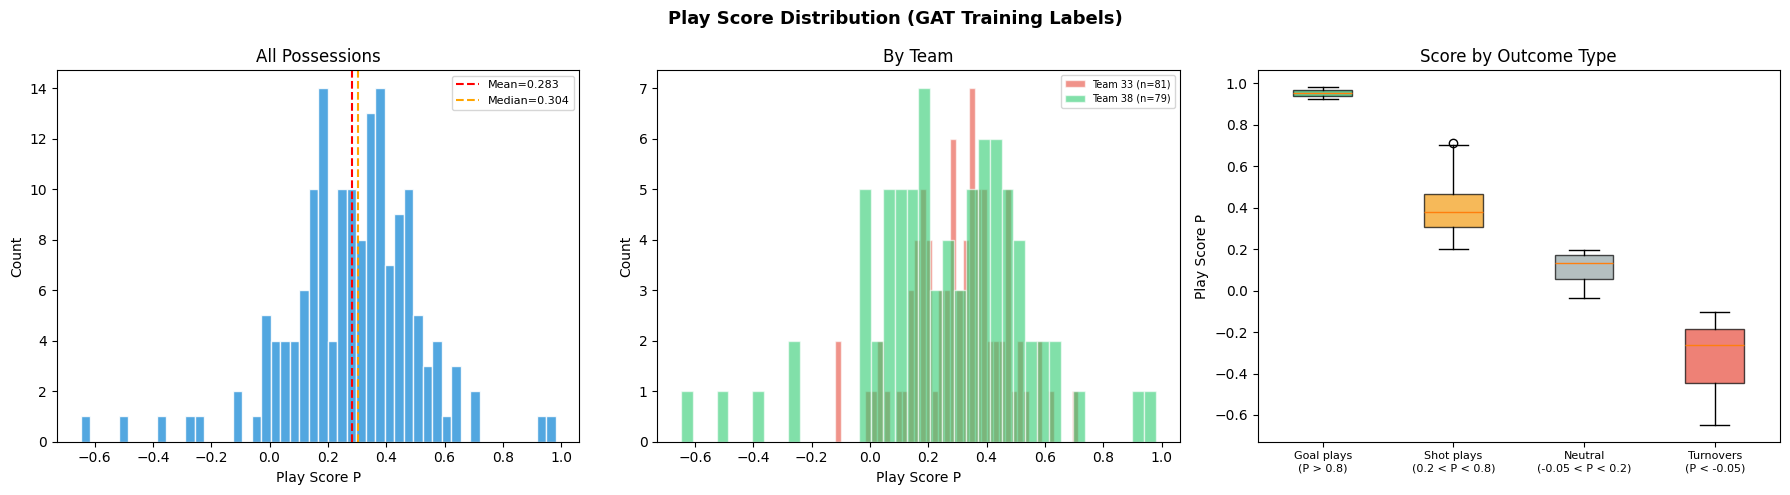


Play score stats:
  Total graphs: 160
  Mean: 0.2829, Std: 0.2233
  Min: -0.6476, Max: 0.9808
  Goals (P > 0.8): 2
  Shots (0.2 < P ≤ 0.8): 103
  Turnovers (P < -0.05): 7


In [160]:
# PLAY SCORE DISTRIBUTION — visualise what the GAT is learning to predict
# Formula: P = (displacement × advancement × sigmoid(t)) + end_bonus

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

all_scores = [g.y.item() for g in graphs]
team_ids_unique = list({g.team_id for g in graphs})

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Play Score Distribution (GAT Training Labels)", fontsize=13, fontweight="bold")

# 1. Overall histogram
ax = axes[0]
ax.hist(all_scores, bins=50, color="#3498db", edgecolor="white", alpha=0.85)
ax.axvline(x=np.mean(all_scores), color="red", linestyle="--", label=f"Mean={np.mean(all_scores):.3f}")
ax.axvline(x=np.median(all_scores), color="orange", linestyle="--", label=f"Median={np.median(all_scores):.3f}")
ax.set_xlabel("Play Score P")
ax.set_ylabel("Count")
ax.set_title("All Possessions")
ax.legend(fontsize=8)

# 2. By team (overlaid)
ax = axes[1]
for tid, color in zip(team_ids_unique, ["#e74c3c", "#2ecc71"]):
    team_scores = [g.y.item() for g in graphs if g.team_id == tid]
    tname = tid[:15]
    ax.hist(team_scores, bins=40, alpha=0.6, label=f"Team {tname} (n={len(team_scores)})",
            edgecolor="white", color=color)
ax.set_xlabel("Play Score P")
ax.set_ylabel("Count")
ax.set_title("By Team")
ax.legend(fontsize=7)

# 3. Score components breakdown — sample 200 graphs
ax = axes[2]
sample_idx = np.random.choice(len(graphs), min(200, len(graphs)), replace=False)
bonus_scores = []
mult_scores = []
for i in sample_idx:
    s = all_scores[i]
    # Approximate: if score > 0.5 likely has goal bonus, if 0.1-0.5 shot bonus
    if s > 0.8:
        bonus_scores.append(s)
    elif s < -0.05:
        mult_scores.append(s)

# Box plot of score ranges
score_ranges = {
    "Goal plays\n(P > 0.8)": [s for s in all_scores if s > 0.8],
    "Shot plays\n(0.2 < P < 0.8)": [s for s in all_scores if 0.2 < s <= 0.8],
    "Neutral\n(-0.05 < P < 0.2)": [s for s in all_scores if -0.05 <= s <= 0.2],
    "Turnovers\n(P < -0.05)": [s for s in all_scores if s < -0.05],
}
labels = list(score_ranges.keys())
data = [v for v in score_ranges.values() if len(v) > 0]
labels = [l for l, v in zip(labels, score_ranges.values()) if len(v) > 0]
bp = ax.boxplot(data, labels=labels, patch_artist=True)
colors_box = ["#27ae60", "#f39c12", "#95a5a6", "#e74c3c"]
for patch, color in zip(bp["boxes"], colors_box[:len(data)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel("Play Score P")
ax.set_title("Score by Outcome Type")
ax.tick_params(axis="x", labelsize=8)

plt.tight_layout()
plt.show()

print(f"\nPlay score stats:")
print(f"  Total graphs: {len(all_scores)}")
print(f"  Mean: {np.mean(all_scores):.4f}, Std: {np.std(all_scores):.4f}")
print(f"  Min: {min(all_scores):.4f}, Max: {max(all_scores):.4f}")
print(f"  Goals (P > 0.8): {sum(1 for s in all_scores if s > 0.8)}")
print(f"  Shots (0.2 < P ≤ 0.8): {sum(1 for s in all_scores if 0.2 < s <= 0.8)}")
print(f"  Turnovers (P < -0.05): {sum(1 for s in all_scores if s < -0.05)}")

In [161]:
class PlayGAT(nn.Module):
    """
    Two-layer Graph Attention Network that predicts a scalar play score.
    Uses edge features (edge_dim=7) in both attention layers.

    Architecture
    ------------
    GATConv(6 → 32, heads=4, concat=True,  edge_dim=7)  →  128-dim per node
    BatchNorm1d(128) + ELU + Dropout
    GATConv(128 → 32, heads=1, concat=False, edge_dim=7) →  32-dim per node
    ELU
    global_mean_pool                                      →  32-dim per graph
    Linear(32, 1)                                         →  scalar play score

    Notes
    -----
    add_self_loops=False is required because the graphs were built without
    self-loops; PyG's default (True) would try to merge edge_attr with
    auto-added self-loop rows, causing a shape mismatch.
    """

    NODE_DIM = 6   # must match g.x.shape[1]
    EDGE_DIM = 7   # must match g.edge_attr.shape[1]

    def __init__(self, hidden: int = 32, heads: int = 4, dropout: float = 0.3):
        super().__init__()
        self.dropout = dropout

        self.conv1 = GATConv(
            self.NODE_DIM, hidden, heads=heads, concat=True,
            edge_dim=self.EDGE_DIM, dropout=dropout, add_self_loops=False,
        )
        self.bn1 = nn.BatchNorm1d(hidden * heads)  # 128

        self.conv2 = GATConv(
            hidden * heads, hidden, heads=1, concat=False,
            edge_dim=self.EDGE_DIM, dropout=dropout, add_self_loops=False,
        )

        self.head = nn.Linear(hidden, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.elu(self.bn1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index, edge_attr=edge_attr))
        x = global_mean_pool(x, batch)          # (batch_size, 32)
        return self.head(x).squeeze(-1)          # (batch_size,)

    def forward_with_attention(self, data):
        """
        Single-graph forward pass returning per-layer attention weights.
        Useful for post-hoc edge attribution.

        Returns
        -------
        pred  : Tensor (1,)
        attn1 : Tensor (E, heads)  — Layer 1 per-head attention weights
        attn2 : Tensor (E, 1)       — Layer 2 attention weights
        """
        x, ei, ea = data.x, data.edge_index, data.edge_attr
        batch = torch.zeros(x.size(0), dtype=torch.long)

        x, (_, attn1) = self.conv1(x, ei, edge_attr=ea, return_attention_weights=True)
        x = F.elu(self.bn1(x))
        x, (_, attn2) = self.conv2(x, ei, edge_attr=ea, return_attention_weights=True)
        x = F.elu(x)
        x = global_mean_pool(x, batch)
        return self.head(x).squeeze(-1), attn1, attn2


# Instantiate and sanity-check
model = PlayGAT(hidden=32, heads=4, dropout=0.3)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f"\nTrainable parameters: {total_params:,}")

with torch.no_grad():
    g0 = graphs[0]
    dummy_batch = torch.zeros(g0.num_nodes, dtype=torch.long)
    out = model(g0.x, g0.edge_index, g0.edge_attr, dummy_batch)
    print(f"\nForward check  — nodes: {g0.num_nodes}, output: {out.shape}, value: {out.item():.4f}")
    pred, a1, a2 = model.forward_with_attention(g0)
    print(f"Attention check — attn1: {a1.shape}, attn2: {a2.shape}")

PlayGAT(
  (conv1): GATConv(6, 32, heads=4)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(128, 32, heads=1)
  (head): Linear(in_features=32, out_features=1, bias=True)
)

Trainable parameters: 6,913

Forward check  — nodes: 13, output: torch.Size([1]), value: 0.2510
Attention check — attn1: torch.Size([33, 4]), attn2: torch.Size([33, 1])


Train: 128 graphs  |  Val: 32 graphs
Epoch   1/50  |  train MSE: 0.2241  |  val MSE: 0.0893
Epoch  10/50  |  train MSE: 0.0595  |  val MSE: 0.0451
Epoch  20/50  |  train MSE: 0.0545  |  val MSE: 0.0571
Epoch  30/50  |  train MSE: 0.0543  |  val MSE: 0.0540
Epoch  40/50  |  train MSE: 0.0430  |  val MSE: 0.0473
Epoch  50/50  |  train MSE: 0.0526  |  val MSE: 0.0532

Training complete.


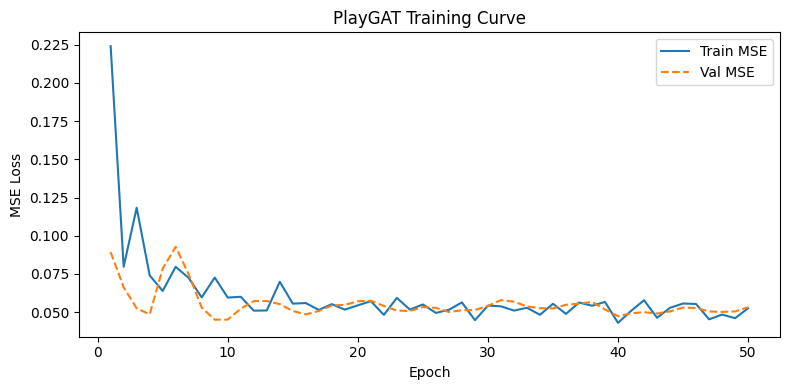

In [162]:
# Training configuration
SEED         = 42
BATCH_SIZE   = 32
LR           = 1e-3
WEIGHT_DECAY = 1e-4
N_EPOCHS     = 50
LOG_EVERY    = 10

torch.manual_seed(SEED)

# 80 / 20 reproducible split
perm    = torch.randperm(len(graphs), generator=torch.Generator().manual_seed(SEED)).tolist()
n_train = int(0.8 * len(graphs))

train_graphs = [graphs[i] for i in perm[:n_train]]
val_graphs   = [graphs[i] for i in perm[n_train:]]

train_loader = DataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_graphs)} graphs  |  Val: {len(val_graphs)} graphs")

# Model, optimiser, loss
model     = PlayGAT(hidden=32, heads=4, dropout=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss()

train_losses: list[float] = []
val_losses:   list[float] = []

# Training loop
for epoch in range(1, N_EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = criterion(pred, batch.y.squeeze(-1))   # batch.y is (B,1); pred is (B,)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch.num_graphs
    avg_train = epoch_loss / len(train_graphs)
    train_losses.append(avg_train)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            pred     = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            val_loss += criterion(pred, batch.y.squeeze(-1)).item() * batch.num_graphs
    avg_val = val_loss / len(val_graphs)
    val_losses.append(avg_val)

    if epoch % LOG_EVERY == 0 or epoch == 1:
        print(f"Epoch {epoch:>3}/{N_EPOCHS}  |  train MSE: {avg_train:.4f}  |  val MSE: {avg_val:.4f}")

print("\nTraining complete.")

# Loss curve
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, N_EPOCHS + 1), train_losses, label="Train MSE")
ax.plot(range(1, N_EPOCHS + 1), val_losses,   label="Val MSE",   linestyle="--")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
ax.set_title("PlayGAT Training Curve")
ax.legend()
plt.tight_layout()
plt.show()

In [163]:
from collections import defaultdict

# Player name lookup
player_id_to_name: dict[str, str] = {}
for _team in dataset.metadata.teams:
    for _p in _team.players:
        player_id_to_name[str(_p.player_id)] = _p.name

# Starting lineups from Kloppy metadata
# player.starting is confirmed True/False in IMPECT open data
_team_starters: dict[str, frozenset[str]] = {}
for _team in dataset.metadata.teams:
    tid      = str(_team.team_id)
    starters = frozenset(str(_p.player_id) for _p in _team.players if _p.starting)
    _team_starters[tid] = starters
    names = [player_id_to_name.get(pid, pid) for pid in sorted(starters)]
    print(f"Team {tid} starters ({len(starters)}): {names}")

# Parse SUBSTITUTION events
_sub_events = df[df["event_type"] == "SUBSTITUTION"].copy()
print(f"\nSubstitution events: {len(_sub_events)}")

_has_receiver = (
    "receiver_player_id" in df.columns
    and _sub_events["receiver_player_id"].notna().any()
)
print(f"receiver_player_id populated for subs: {_has_receiver}")

# sub_log[team_id] = sorted list of (period_id, timestamp_sec, off_id, on_id)
_sub_log: dict[str, list[tuple[int, float, str, str]]] = defaultdict(list)

if _has_receiver and len(_sub_events) > 0:
    for _, row in _sub_events.iterrows():
        tid    = str(row["team_id"])
        period = int(row["period_id"])
        t_sec  = float(row["timestamp_sec"])
        off_id = str(row["player_id"])
        on_id  = str(row.get("receiver_player_id", float("nan")))
        if on_id not in ("nan", "UNKNOWN", "None"):
            _sub_log[tid].append((period, t_sec, off_id, on_id))
    for tid, subs in _sub_log.items():
        subs.sort(key=lambda x: (x[0], x[1]))
        print(f"  Team {tid}: {len(subs)} substitution(s) tracked")
else:
    print("  Falling back to period-appearance heuristic.")

_sub_log_frozen       = dict(_sub_log)
_team_starters_frozen = dict(_team_starters)


def get_lineup_at_time(team_id: str, period_id: int, timestamp_sec: float) -> frozenset[str]:
    """
    Return the set of player IDs on the field for `team_id` at the given time.

    Primary path (when substitution data is available):
      Starts from the team's starting XI, applies any subs that occurred at
      or before (period_id, timestamp_sec) in chronological order.

    Fallback path (no sub data):
      Returns all players who appeared in any event for this team in this
      period up to this timestamp (safe over-approximation).

    Always excludes "UNKNOWN".
    """
    tid = str(team_id)

    if _sub_log_frozen:
        lineup = set(_team_starters_frozen.get(tid, frozenset()))
        for s_period, s_t, off_id, on_id in _sub_log_frozen.get(tid, []):
            if (s_period, s_t) <= (period_id, timestamp_sec):
                lineup.discard(off_id)
                lineup.add(on_id)
        lineup.discard("UNKNOWN")
        return frozenset(lineup)
    else:
        mask = (
            (df["team_id"].astype(str) == tid) &
            (
                (df["period_id"] < period_id) |
                ((df["period_id"] == period_id) & (df["timestamp_sec"] <= timestamp_sec))
            ) &
            (df["player_id"] != "UNKNOWN")
        )
        players = set(df[mask]["player_id"].unique())
        players.discard("UNKNOWN")
        return frozenset(players)


# Sanity check
for _team in dataset.metadata.teams:
    tid = str(_team.team_id)
    lu  = get_lineup_at_time(tid, 1, 0.0)
    print(f"\nTeam {tid} at kick-off ({len(lu)} players):")
    for pid in sorted(lu):
        print(f"  {pid}: {player_id_to_name.get(pid, '???')}")

Team 38 starters (11): ['Mitchell Weiser', 'Milos Veljkovic', 'Leonardo Bittencourt', 'Anthony Jung', 'Jens Stage', 'Marco Friedl', 'Amos Pieper', 'Senne Lynen', 'Jiri Pavlenka', 'Niclas Füllkrug', 'Marvin Ducksch']
Team 33 starters (11): ['Leon Goretzka', 'Sven Ulreich', 'Leroy Sané', 'Harry Kane', 'Kingsley Coman', 'Alphonso Davies', 'Min-jae Kim', 'Jamal Musiala', 'Dayot Upamecano', 'Noussair Mazraoui', 'Joshua Kimmich']

Substitution events: 10
receiver_player_id populated for subs: False
  Falling back to period-appearance heuristic.

Team 38 at kick-off (0 players):

Team 33 at kick-off (1 players):
  204: Leroy Sané


Inference complete: 160 graphs
Predicted score range: [0.093, 0.422]
Unique players in graphs: 32

Player Interaction Matrix (top-left 8 × 8):
                      Mitchell Weiser  Milos Veljkovic  Leon Goretzka  \
Mitchell Weiser                 0.037            0.005          0.006   
Milos Veljkovic                 0.005            0.049          0.002   
Leon Goretzka                   0.006            0.002          0.073   
Leon Opitz                      0.000            0.006          0.000   
Leonardo Bittencourt            0.002            0.003          0.004   
Anthony Jung                    0.000            0.009          0.002   
Sven Ulreich                    0.004            0.000          0.012   
Jens Stage                      0.008            0.004          0.005   

                      Leon Opitz  Leonardo Bittencourt  Anthony Jung  \
Mitchell Weiser            0.000                 0.002         0.000   
Milos Veljkovic            0.006                 0.003 

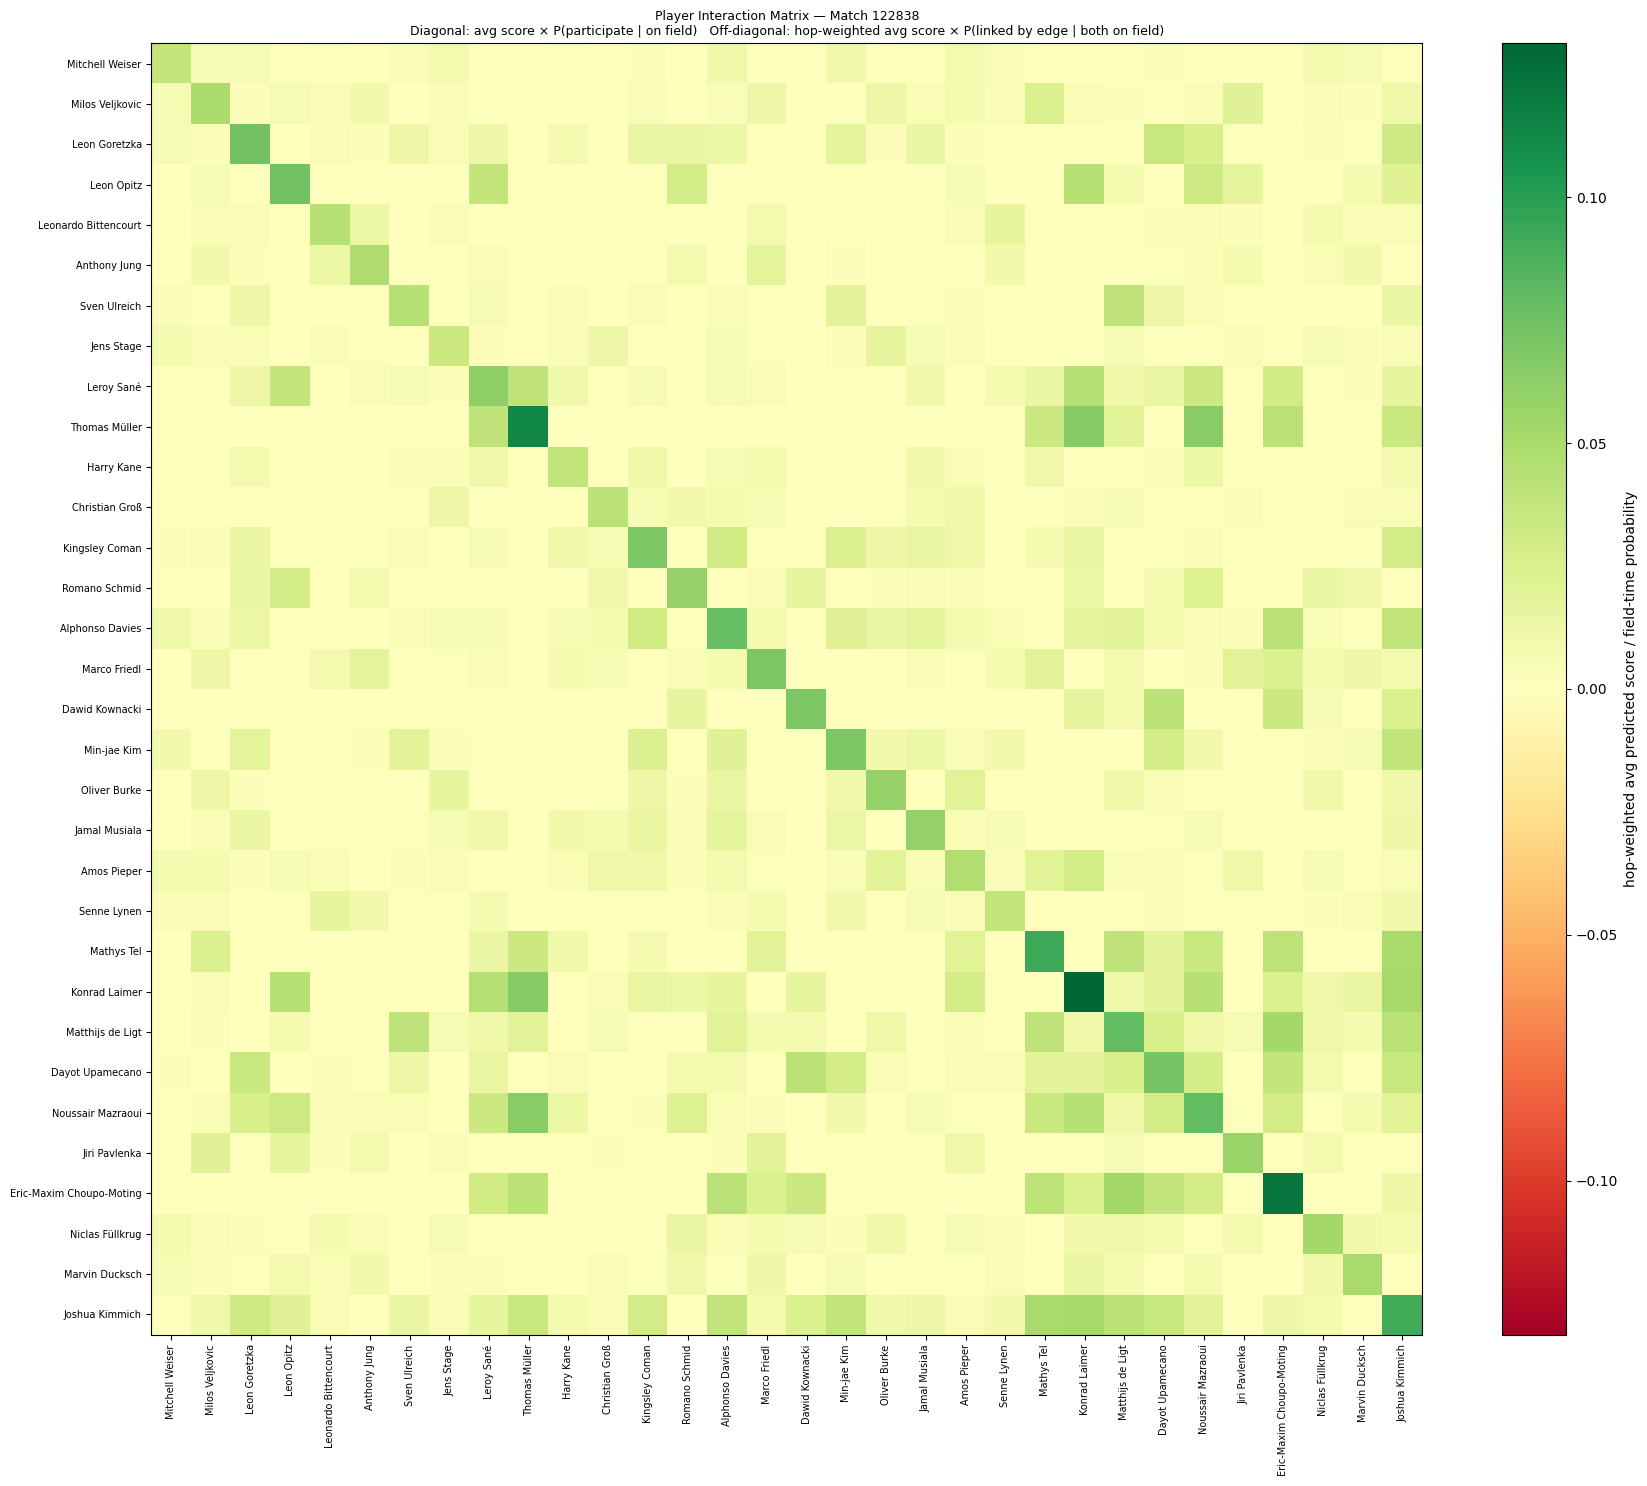


Matrix shape: (32, 32)
Value range:  [0.0000, 0.1313]


In [164]:
# Step 1: Model inference on every graph
# Iterate one graph at a time (DataLoader not used here because g.player_ids /
# g.team_id / g.period_id / g.t_start are non-tensor attributes that are not
# collated by PyG's Batch).
model.eval()
predicted_scores: list[float] = []
with torch.no_grad():
    for g in graphs:
        dummy_batch = torch.zeros(g.num_nodes, dtype=torch.long)
        pred = model(g.x, g.edge_index, g.edge_attr, dummy_batch)
        predicted_scores.append(pred.item())

print(f"Inference complete: {len(predicted_scores)} graphs")
print(f"Predicted score range: [{min(predicted_scores):.3f}, {max(predicted_scores):.3f}]")

# Step 2: Build player universe (both teams, excluding UNKNOWN)
all_pids: list[str] = sorted(
    {pid for g in graphs for pid in g.player_ids if pid != "UNKNOWN"}
)
n_players  = len(all_pids)
pid_to_idx = {pid: i for i, pid in enumerate(all_pids)}
away_team_id = str(dataset.metadata.teams[1].team_id)
print(f"Unique players in graphs: {n_players}")

# Step 3: Accumulate statistics
# score_sum[i, j]          — weighted sum of predicted scores over plays where i & j interact
# participation_count[i]   — # plays player i appeared in as a node
# field_plays[i]           — # plays during which player i was on the field
# field_pairs[i, j]        — # plays during which both i and j were on field

score_sum           = np.zeros((n_players, n_players), dtype=np.float64)
participation_count = np.zeros(n_players,               dtype=np.float64)
field_plays         = np.zeros(n_players,               dtype=np.float64)
field_pairs         = np.zeros((n_players, n_players),  dtype=np.float64)

for g, pred_score in zip(graphs, predicted_scores):
    # Full on-field lineup for this play (both teams)
    opp_tid     = away_team_id if g.team_id == home_team_id else home_team_id
    lineup_poss = get_lineup_at_time(g.team_id, g.period_id, g.t_start)
    lineup_opp  = get_lineup_at_time(opp_tid,   g.period_id, g.t_start)
    full_lineup = lineup_poss | lineup_opp
    lu_indices  = [pid_to_idx[pid] for pid in full_lineup if pid in pid_to_idx]

    # field_plays denominator
    for li in lu_indices:
        field_plays[li] += 1.0

    # field_pairs denominator (symmetric)
    for ii, li in enumerate(lu_indices):
        for lj in lu_indices[ii:]:
            field_pairs[li, lj] += 1.0
            if li != lj:
                field_pairs[lj, li] += 1.0

    # Diagonal: each unique participating player
    participating = {pid_to_idx[pid] for pid in g.player_ids if pid in pid_to_idx}
    for pi in participating:
        score_sum[pi, pi]       += pred_score
        participation_count[pi] += 1.0

    # Off-diagonal: edge-linked player PAIRS (hop-proximity weighted)
    # Real edges (edge_type=1.0) get weight 1.0.
    # Synthetic skip-k edges store hop proximity weight 1/k in action_distance (index 4).
    # If a pair is connected by multiple edges, keep the highest weight (max → real wins).
    pair_weights: dict[tuple[int, int], float] = {}
    for e in range(g.edge_index.shape[1]):
        src_pid = g.player_ids[g.edge_index[0, e].item()]
        dst_pid = g.player_ids[g.edge_index[1, e].item()]
        if src_pid == "UNKNOWN" or dst_pid == "UNKNOWN":
            continue
        if src_pid not in pid_to_idx or dst_pid not in pid_to_idx:
            continue
        pi, pj = pid_to_idx[src_pid], pid_to_idx[dst_pid]
        if pi == pj:
            continue
        pair   = (min(pi, pj), max(pi, pj))
        weight = 1.0 if g.edge_attr[e, 0].item() == 1.0 else g.edge_attr[e, 4].item()
        pair_weights[pair] = max(pair_weights.get(pair, 0.0), weight)

    for (pi, pj), w in pair_weights.items():
        score_sum[pi, pj] += pred_score * w
        score_sum[pj, pi] += pred_score * w

# Step 4: Build the interaction matrix
#
# Off-diagonal [i,j]:
#   = weighted_score_sum[i,j] / field_pairs[i,j]
#   Weighting by hop proximity dampens inflation from distant synthetic connections.
#
# Diagonal [i,i]:
#   = avg_predicted_score_when_player_participates  ×  P(participates | on field)
#   = score_sum[i,i] / field_plays[i]

interaction_matrix = np.zeros((n_players, n_players), dtype=np.float64)

with np.errstate(invalid="ignore", divide="ignore"):
    off = np.where(field_pairs > 0, score_sum / field_pairs, 0.0)
    np.fill_diagonal(off, 0.0)
    interaction_matrix += off

    diag_vals = np.where(field_plays > 0, np.diag(score_sum) / field_plays, 0.0)
    np.fill_diagonal(interaction_matrix, diag_vals)

# Step 5a: DataFrame display
player_names   = [player_id_to_name.get(pid, pid) for pid in all_pids]
interaction_df = pd.DataFrame(interaction_matrix, index=player_names, columns=player_names)

print("\nPlayer Interaction Matrix (top-left 8 × 8):")
with pd.option_context("display.float_format", "{:.3f}".format, "display.max_columns", 8):
    print(interaction_df.iloc[:8, :8])

# Step 5b: Heatmap
fig_size = max(10, n_players * 0.55)
fig, ax  = plt.subplots(figsize=(fig_size, fig_size * 0.85))

vmax = np.abs(interaction_matrix).max() or 1.0
norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
im   = ax.imshow(interaction_matrix, cmap="RdYlGn", norm=norm, aspect="auto")

ax.set_xticks(range(n_players))
ax.set_yticks(range(n_players))
ax.set_xticklabels(player_names, rotation=90, fontsize=7)
ax.set_yticklabels(player_names, fontsize=7)

plt.colorbar(im, ax=ax, label="hop-weighted avg predicted score / field-time probability")
ax.set_title(
    f"Player Interaction Matrix — Match {MATCH_ID}\n"
    "Diagonal: avg score × P(participate | on field)   "
    "Off-diagonal: hop-weighted avg score × P(linked by edge | both on field)",
    fontsize=9,
)
plt.tight_layout()
plt.show()

print(f"\nMatrix shape: {interaction_matrix.shape}")
print(f"Value range:  [{interaction_matrix.min():.4f}, {interaction_matrix.max():.4f}]")

All players have assigned positions.


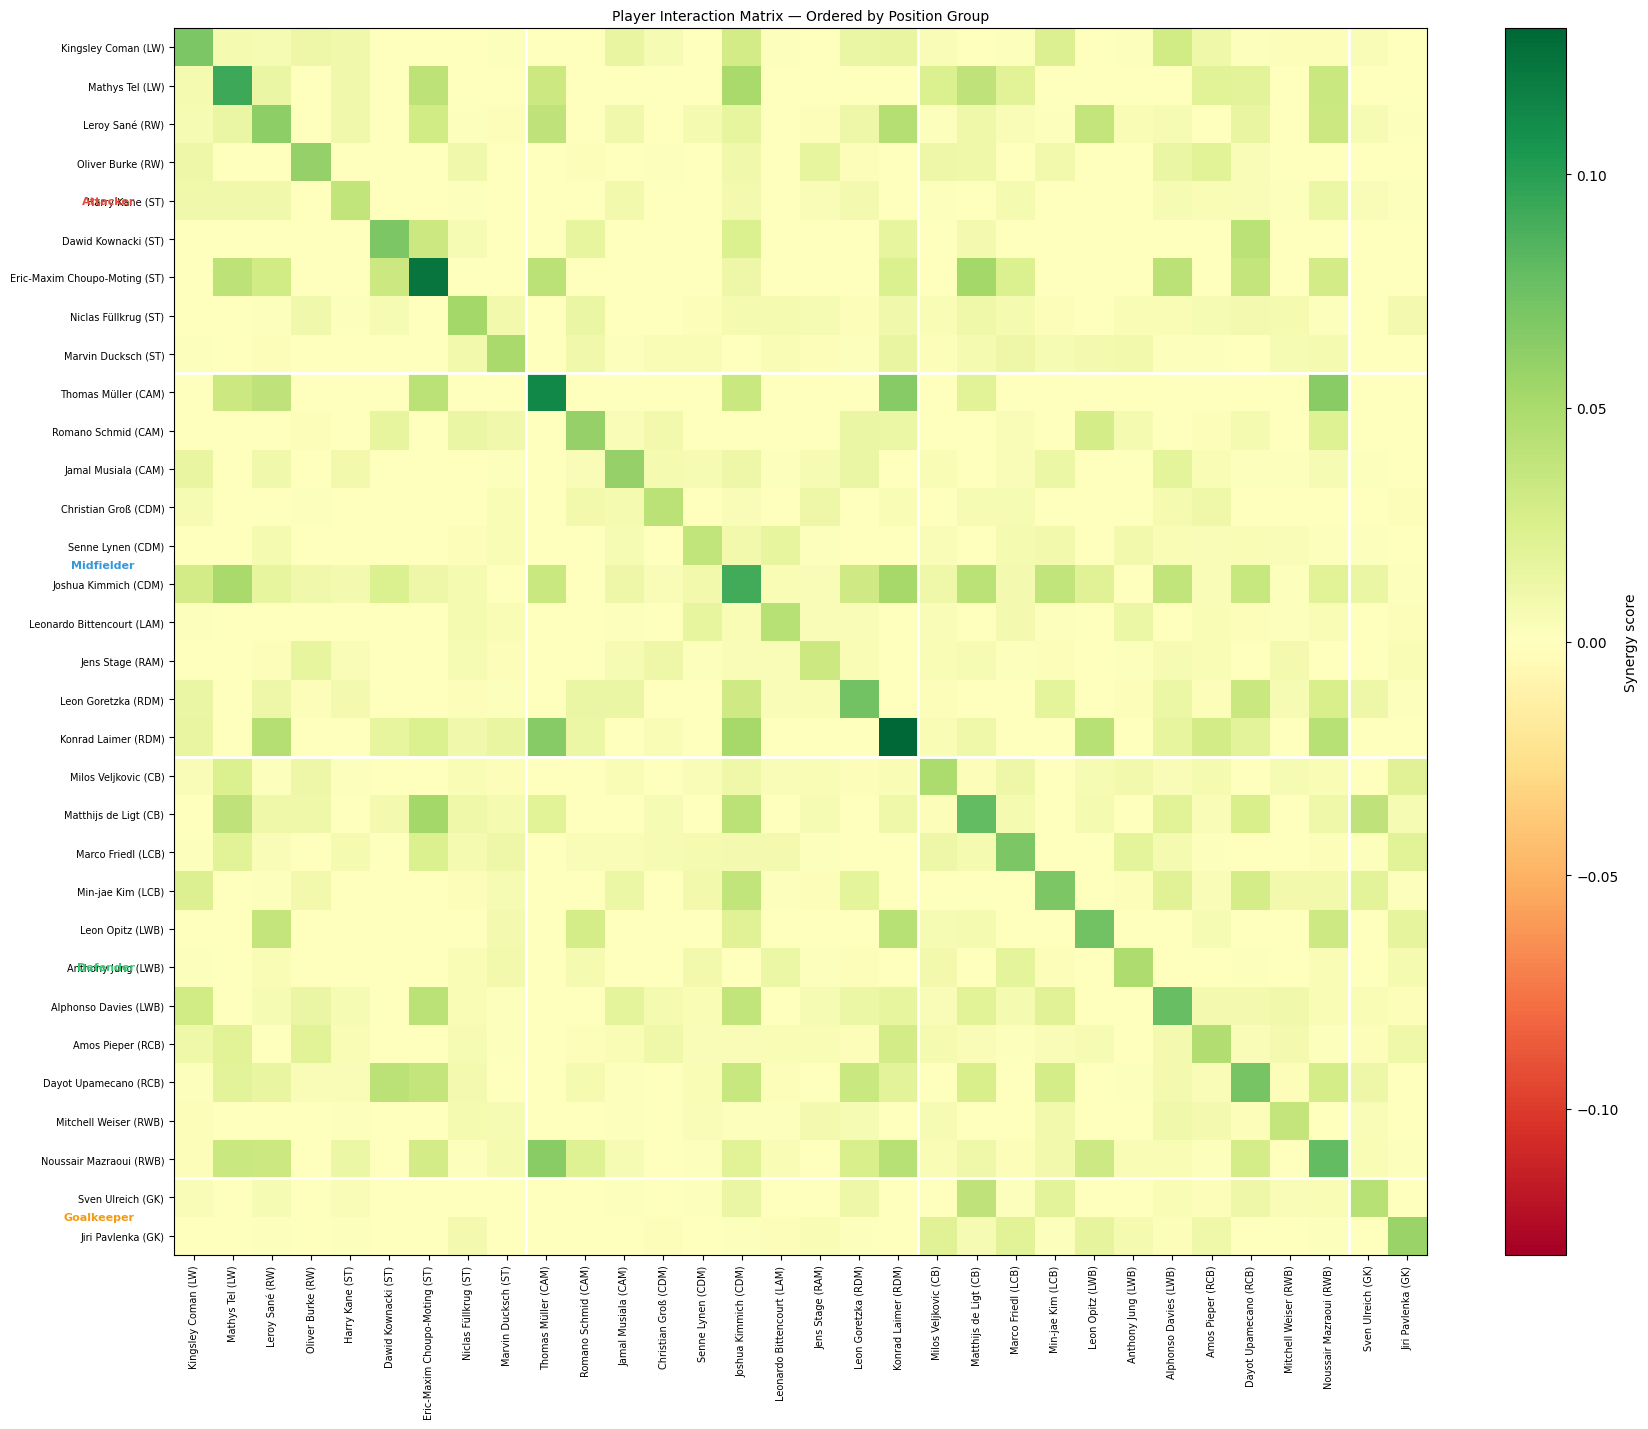


Players by position group:

Attacker (9):
  Kingsley Coman (LW, team 33)
  Mathys Tel (LW, team 33)
  Leroy Sané (RW, team 33)
  Oliver Burke (RW, team 38)
  Harry Kane (ST, team 33)
  Dawid Kownacki (ST, team 38)
  Eric-Maxim Choupo-Moting (ST, team 33)
  Niclas Füllkrug (ST, team 38)
  Marvin Ducksch (ST, team 38)

Midfielder (10):
  Thomas Müller (CAM, team 33)
  Romano Schmid (CAM, team 38)
  Jamal Musiala (CAM, team 33)
  Christian Groß (CDM, team 38)
  Senne Lynen (CDM, team 38)
  Joshua Kimmich (CDM, team 33)
  Leonardo Bittencourt (LAM, team 38)
  Jens Stage (RAM, team 38)
  Leon Goretzka (RDM, team 33)
  Konrad Laimer (RDM, team 33)

Defender (11):
  Milos Veljkovic (CB, team 38)
  Matthijs de Ligt (CB, team 33)
  Marco Friedl (LCB, team 38)
  Min-jae Kim (LCB, team 33)
  Leon Opitz (LWB, team 38)
  Anthony Jung (LWB, team 38)
  Alphonso Davies (LWB, team 33)
  Amos Pieper (RCB, team 38)
  Dayot Upamecano (RCB, team 33)
  Mitchell Weiser (RWB, team 38)
  Noussair Mazraoui (RW

In [165]:
# POSITION MAPPING & MATRIX REORDERING

# Configurable position grouping
# Edit these to change which kloppy position codes map to each group.
POSITION_GROUPS: dict[str, list[str]] = {
    "Attacker":    ["ST", "LW", "RW", "CF", "SS"],
    "Midfielder":  ["CDM", "LDM", "RDM", "CAM", "LAM", "RAM",
                     "CM", "LCM", "RCM", "LM", "RM"],
    "Defender":    ["CB", "LCB", "RCB", "LWB", "RWB", "LB", "RB"],
    "Goalkeeper":  ["GK"],
}

# Display order for the reordered matrix (top -> bottom)
GROUP_ORDER = ["Attacker", "Midfielder", "Defender", "Goalkeeper"]

# Manual position overrides — checked FIRST, before kloppy starting_position.
# Substitutes in kloppy don't have starting_position set, and some starters
# have incorrect positions in the data. Add player NAME -> position CODE here.
POSITION_OVERRIDES: dict[str, str] = {
    # Bremen subs
    "Romano Schmid":   "CAM",
    "Dawid Kownacki":  "ST",
    "Oliver Burke":    "RW",
    "Nicolai Rapp":    "CDM",
    "Christian Groß":  "CDM",
    "Ilia Gruev":      "CDM",
    "Leon Opitz":      "LWB",
    "Justin Njinmah":  "LW",
    "Michael Zetterer": "GK",
    # Bayern subs
    "Thomas Müller":            "CAM",
    "Eric-Maxim Choupo-Moting": "ST",
    "Benjamin Pavard":          "RCB",
    "Konrad Laimer":            "RDM",
    "Matthijs de Ligt":         "CB",
    "Ryan Gravenberch":         "CDM",
    "Frans Krätzig":            "LWB",
    "Tom Ritzy Hülsmann":       "GK",
    "Mathys Tel":               "LW",
    "Manuel Neuer":             "GK",
    "Joshua Kimmich":           "CDM",
}

# Build player_id -> (position_code, position_group, team_id)
_code_to_group = {code: grp for grp, codes in POSITION_GROUPS.items() for code in codes}

player_position: dict[str, str] = {}   # pid -> position code  (e.g. "LW")
player_group:    dict[str, str] = {}   # pid -> group name     (e.g. "Attacker")
player_team:     dict[str, str] = {}   # pid -> team_id string

for _team in dataset.metadata.teams:
    tid = str(_team.team_id)
    for _p in _team.players:
        pid  = str(_p.player_id)
        name = _p.name if hasattr(_p, "name") else player_id_to_name.get(pid, pid)
        player_team[pid] = tid

        # 1. Try manual override FIRST (takes priority)
        if name in POSITION_OVERRIDES:
            code = POSITION_OVERRIDES[name]
        # 2. Fall back to kloppy starting_position
        elif _p.starting_position:
            code = _p.starting_position.code
        else:
            code = None

        if code:
            player_position[pid] = code
            player_group[pid] = _code_to_group.get(code, "Unknown")
        else:
            player_position[pid] = "?"
            player_group[pid] = "Unknown"

# Report unknown players so the user can add overrides
unknowns = [pid for pid in all_pids if player_group.get(pid) == "Unknown"]
if unknowns:
    print("⚠ Players with unknown position (add to POSITION_OVERRIDES):")
    for pid in unknowns:
        print(f"  '{player_id_to_name.get(pid, pid)}': '???',  # team {player_team.get(pid, '?')}")
else:
    print("All players have assigned positions.")

# Reorder the interaction matrix by position group
ordered_pids: list[str] = []
for grp in GROUP_ORDER:
    grp_pids = [pid for pid in all_pids if player_group.get(pid) == grp]
    grp_pids.sort(key=lambda p: player_position.get(p, ""))
    ordered_pids.extend(grp_pids)
# Append any players without a known group
leftover = [pid for pid in all_pids if pid not in ordered_pids]
ordered_pids.extend(leftover)

ordered_names = [player_id_to_name.get(pid, pid) for pid in ordered_pids]
ordered_labels = [
    f"{player_id_to_name.get(pid, pid)} ({player_position.get(pid, '?')})"
    for pid in ordered_pids
]

# Reindex the DataFrame
interaction_ordered = interaction_df.loc[
    [player_id_to_name.get(p, p) for p in ordered_pids],
    [player_id_to_name.get(p, p) for p in ordered_pids],
]

# Heatmap with position-group color bands
group_colors = {"Attacker": "#e74c3c", "Midfielder": "#3498db",
                "Defender": "#2ecc71", "Goalkeeper": "#f39c12", "Unknown": "#95a5a6"}

fig, ax = plt.subplots(figsize=(max(10, len(ordered_pids) * 0.55),
                                 max(8, len(ordered_pids) * 0.45)))

vmax = np.abs(interaction_ordered.values).max() or 1.0
norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
im = ax.imshow(interaction_ordered.values, cmap="RdYlGn", norm=norm, aspect="auto")

ax.set_xticks(range(len(ordered_pids)))
ax.set_yticks(range(len(ordered_pids)))
ax.set_xticklabels(ordered_labels, rotation=90, fontsize=7)
ax.set_yticklabels(ordered_labels, fontsize=7)

# Draw position-group separator lines
cum = 0
for grp in GROUP_ORDER:
    count = sum(1 for pid in ordered_pids if player_group.get(pid) == grp)
    if count > 0 and cum > 0:
        ax.axhline(y=cum - 0.5, color="white", linewidth=2)
        ax.axvline(x=cum - 0.5, color="white", linewidth=2)
    mid = cum + count / 2 - 0.5
    ax.text(-1.5, mid, grp, ha="right", va="center", fontsize=8,
            fontweight="bold", color=group_colors.get(grp, "gray"))
    cum += count

plt.colorbar(im, ax=ax, label="Synergy score")
ax.set_title("Player Interaction Matrix — Ordered by Position Group", fontsize=10)
plt.tight_layout()
plt.show()

# Summary table
print("\nPlayers by position group:")
for grp in GROUP_ORDER:
    members = [f"  {player_id_to_name.get(pid, pid)} ({player_position.get(pid, '?')}, team {player_team.get(pid, '?')})"
               for pid in ordered_pids if player_group.get(pid) == grp]
    print(f"\n{grp} ({len(members)}):")
    for m in members:
        print(m)

DIAGONAL COMPARISON: Old (GAT only) vs New (GAT + PSI + Appearances)
Player                         Group          Old Diag      PSI  App Bonus   New Diag    Delta
------------------------------------------------------------------------------------------
Harry Kane                     Attacker         0.4708   1.8373     0.7895     0.6092  +0.1384
Leroy Sané                     Attacker         0.8491   3.0597     0.9164     0.9875  +0.1384
Amos Pieper                    Defender         0.5039   1.6258     0.8449     0.6196  +0.1157
Jens Stage                     Midfielder       0.1777   0.2291     0.7895     0.2699  +0.0923
Mitchell Weiser                Defender         0.2441   0.4497     0.7997     0.3351  +0.0910
Senne Lynen                    Midfielder       0.1804   0.0704     0.7679     0.2538  +0.0734
Milos Veljkovic                Defender         0.3282   0.4859     0.8365     0.3988  +0.0705
Jiri Pavlenka                  Goalkeeper       0.4579   0.9091     0.8760     0

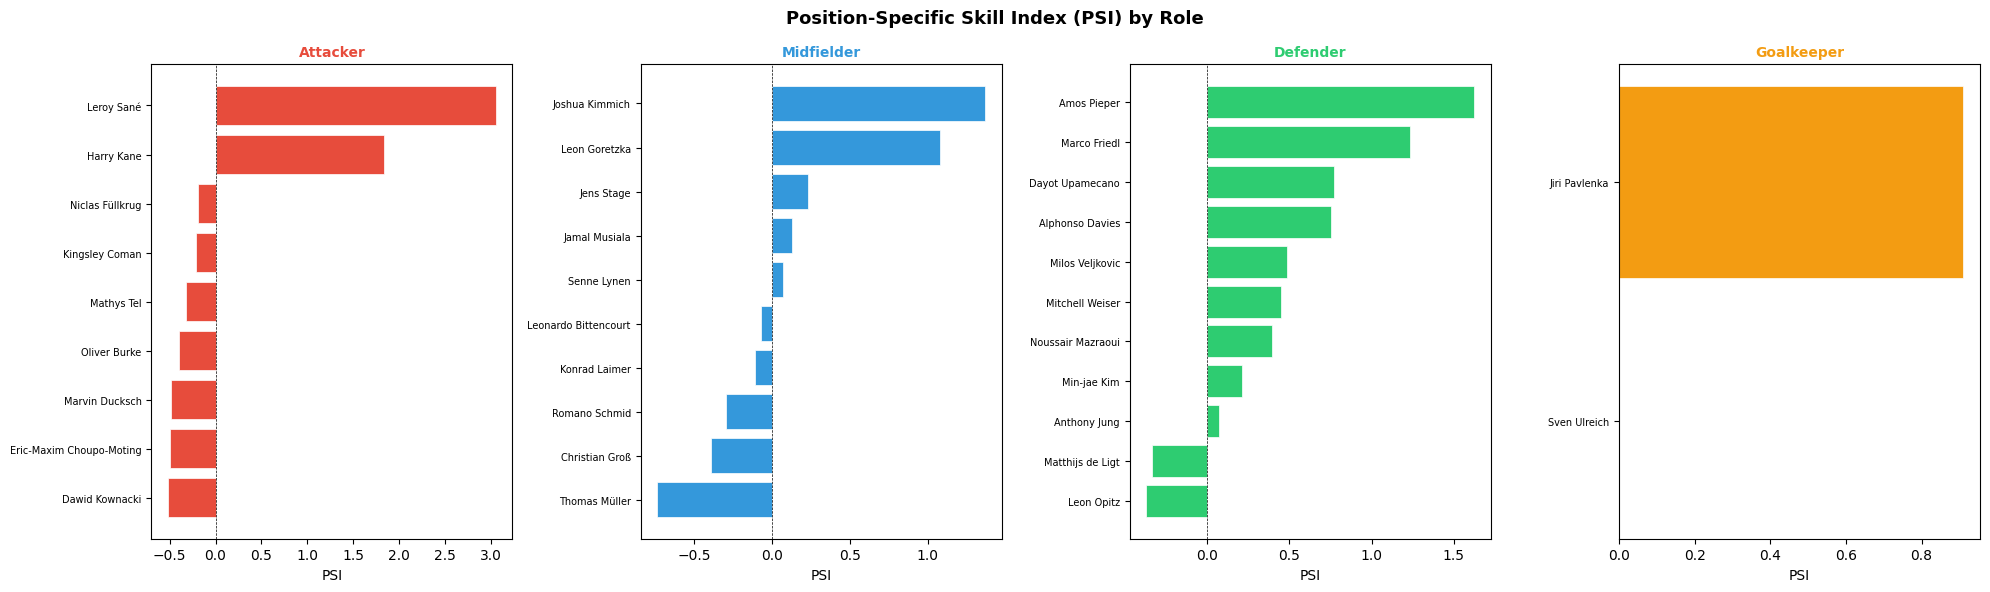

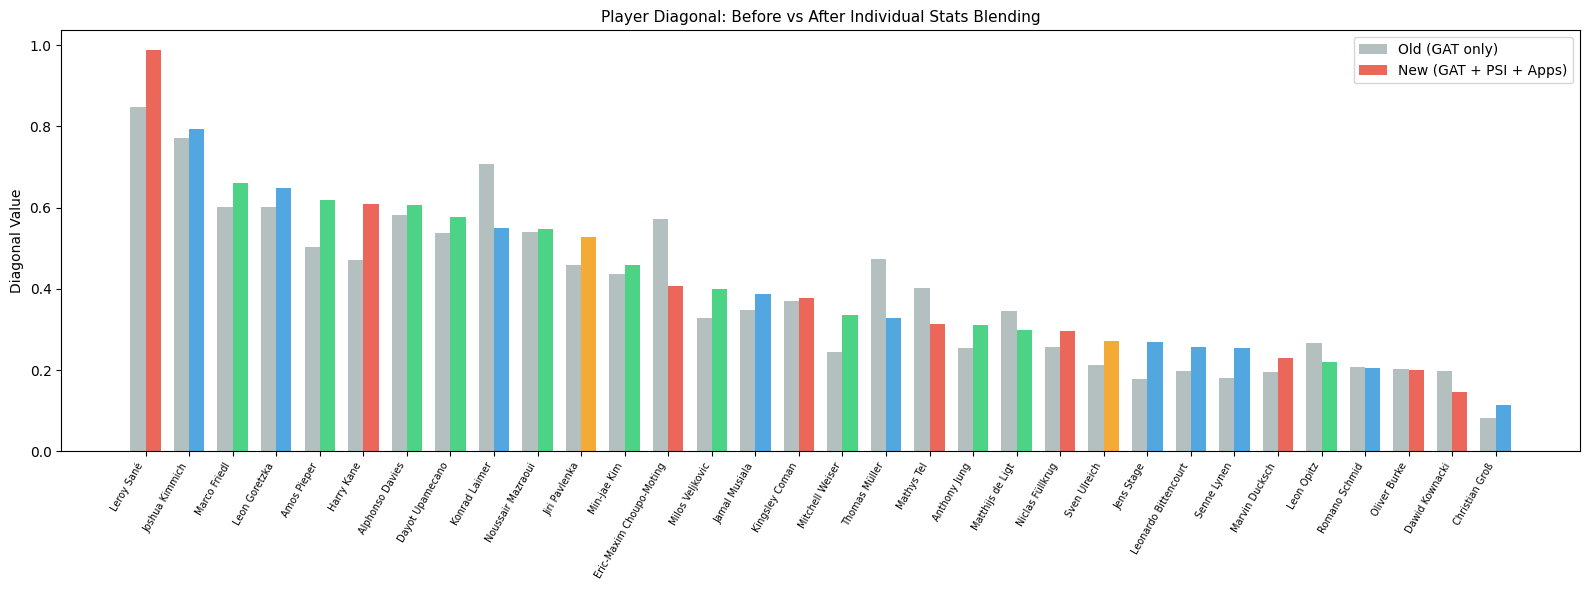

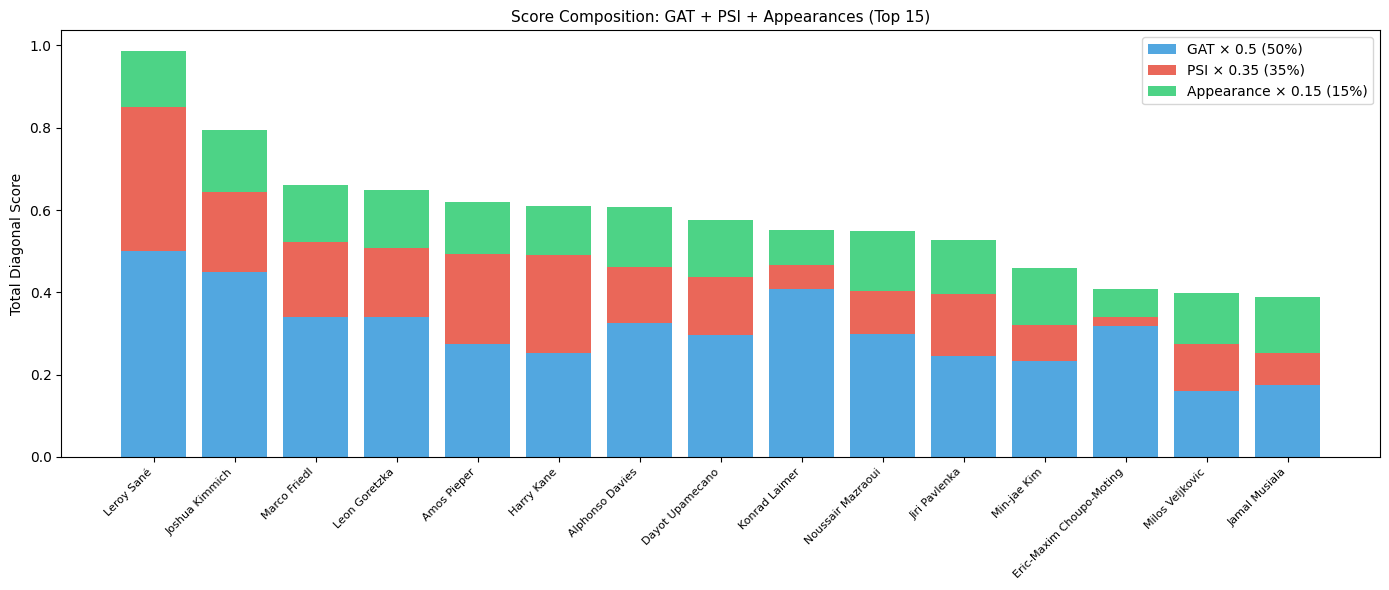



RAW STATS FOR KEY PLAYERS:
  Mitchell Weiser: apps=24, {'successful_duels': 3, 'recoveries': 5, 'successful_passes': 6, 'clearances': 1, 'blocks': 2, 'key_passes': 1, 'interceptions': 2, 'total_shots': 1}
  Milos Veljkovic: apps=28, {'successful_passes': 20, 'interceptions': 3, 'recoveries': 2, 'successful_duels': 1, 'clearances': 2, 'blocks': 3}
  Leon Goretzka: apps=44, {'successful_passes': 63, 'recoveries': 8, 'clearances': 4, 'successful_duels': 4, 'interceptions': 5, 'total_shots': 3, 'shots_on_target': 1, 'key_passes': 1, 'blocks': 2}
  Leon Opitz: apps=5, {'successful_passes': 1, 'successful_duels': 2, 'clearances': 1, 'interceptions': 1}
  Leonardo Bittencourt: apps=24, {'successful_passes': 11, 'successful_duels': 3, 'clearances': 2, 'interceptions': 2, 'blocks': 2, 'recoveries': 1, 'key_passes': 1, 'total_shots': 1}
  Anthony Jung: apps=27, {'successful_passes': 14, 'recoveries': 6, 'interceptions': 2, 'blocks': 1, 'successful_duels': 1, 'clearances': 1}
  Sven Ulreich: ap

In [170]:
# INDIVIDUAL PLAYER STATS + APPEARANCE BONUS
# Blends position-specific skill index (PSI) and appearance bonus into the diagonal.
# Formula: diagonal[i] = GAT_avg[i] + beta * PSI[i] + gamma * appearance_bonus[i]
# Split: ~60% progression/synergy (GAT), ~30% individual stats, ~10% appearances.

from collections import Counter

# Config — old additive weights (kept for reference in comparison table)
BETA  = 0.50   # used in comparison table display
GAMMA = 0.17   # used in comparison table display

# Position-specific stat weights — what matters for each role
ATTACKER_WEIGHTS = {
    "goals": 0.40, "shots_on_target": 0.25, "total_shots": 0.10,
    "successful_passes": 0.10, "successful_duels": 0.15,
}
MIDFIELDER_WEIGHTS = {
    "successful_passes": 0.20, "key_passes": 0.30, "interceptions": 0.15,
    "successful_duels": 0.20, "recoveries": 0.15,
}
DEFENDER_WEIGHTS = {
    "interceptions": 0.25, "clearances": 0.20, "blocks": 0.20,
    "successful_duels": 0.20, "recoveries": 0.15,
}
GOALKEEPER_WEIGHTS = {
    "saves": 0.80, "successful_passes": 0.20,
}

WEIGHT_MAP = {
    "Attacker": ATTACKER_WEIGHTS,
    "Midfielder": MIDFIELDER_WEIGHTS,
    "Defender": DEFENDER_WEIGHTS,
    "Goalkeeper": GOALKEEPER_WEIGHTS,
}

# ── Step 1: Tally per-player event stats from graph event_data ──
player_event_stats: dict[str, Counter] = defaultdict(Counter)
player_appearances: dict[str, int] = defaultdict(int)

for g in graphs:
    unique_pids = {pid for pid in g.player_ids if pid != "UNKNOWN"}
    for pid in unique_pids:
        player_appearances[pid] += 1

    if hasattr(g, "event_data"):
        for ev in g.event_data:
            pid = ev["player_id"]
            if pid == "UNKNOWN":
                continue
            etype = ev["event_type"]
            result = ev["result"].upper()
            success = ev["success"]

            if etype == "SHOT":
                player_event_stats[pid]["total_shots"] += 1
                if "GOAL" in result:
                    player_event_stats[pid]["goals"] += 1
                    player_event_stats[pid]["shots_on_target"] += 1
                elif "SAVED" in result:
                    player_event_stats[pid]["shots_on_target"] += 1
            elif etype == "PASS":
                if success:
                    player_event_stats[pid]["successful_passes"] += 1
                if success and ev["end_x"] > 35.0:
                    player_event_stats[pid]["key_passes"] += 1
            elif etype == "DUEL" and result == "WON":
                player_event_stats[pid]["successful_duels"] += 1
            elif etype == "INTERCEPTION":
                player_event_stats[pid]["interceptions"] += 1
            elif etype == "CLEARANCE":
                player_event_stats[pid]["clearances"] += 1
            elif "BLOCK" in etype:
                player_event_stats[pid]["blocks"] += 1
            elif etype == "RECOVERY":
                player_event_stats[pid]["recoveries"] += 1
            elif etype == "GOALKEEPER":
                gk_type = str(ev.get("goalkeeper_type", "NONE")).upper()
                if gk_type == "SAVE":
                    player_event_stats[pid]["saves"] += 1

# ── Step 2: Compute PSI (Position-Specific Skill Index) ──
# Outfielders: z-score normalize each stat, dot-product with position weights
# Goalkeepers: special formula — save_rate = saves / appearances, PSI = save_rate * 10.0
all_stat_names = set()
for w in WEIGHT_MAP.values():
    all_stat_names.update(w.keys())

raw_arrays = {
    s: np.array([float(player_event_stats[pid].get(s, 0)) for pid in all_pids])
    for s in all_stat_names
}

z_scored = {}
for s, vals in raw_arrays.items():
    mu, sigma = vals.mean(), vals.std()
    z_scored[s] = (vals - mu) / sigma if sigma > 0 else np.zeros_like(vals)

psi = {}
for idx, pid in enumerate(all_pids):
    grp = player_group.get(pid, "Midfielder")

    # Goalkeepers get special PSI: save rate scaled to comparable range
    if grp == "Goalkeeper":
        saves = float(player_event_stats[pid].get("saves", 0))
        apps = float(player_appearances.get(pid, 1))
        save_rate = saves / max(apps, 1.0)
        psi[pid] = save_rate * 10.0
    else:
        weights = WEIGHT_MAP.get(grp, MIDFIELDER_WEIGHTS)
        score = sum(weights.get(s, 0.0) * z_scored[s][idx] for s in weights)
        psi[pid] = score

# ── Step 3: Compute appearance bonus (logarithmic, normalized to [0, 1]) ──
raw_app = {pid: math.log(1 + player_appearances.get(pid, 0)) for pid in all_pids}
max_app = max(raw_app.values()) if raw_app else 1.0
if max_app == 0:
    max_app = 1.0
app_bonus = {pid: v / max_app for pid, v in raw_app.items()}

# ── Step 4: Blend into the diagonal ──
# Weights that guarantee the target composition (must sum to 1.0)
W_GAT = 0.50   # 50% from GAT progression/synergy score
W_PSI = 0.35   # 35% from individual stats (PSI)
W_APP = 0.15   # 15% from appearance bonus

old_diag = np.diag(interaction_matrix).copy()

# Min-max normalize GAT diagonal to [0, 1]
gat_min, gat_max = old_diag.min(), old_diag.max()
norm_gat_arr = (old_diag - gat_min) / (gat_max - gat_min) if gat_max > gat_min else np.zeros_like(old_diag)

# Min-max normalize PSI to [0, 1] (preserves relative differences, negatives map near 0)
psi_vals_arr = np.array([psi.get(pid, 0.0) for pid in all_pids])
psi_min, psi_max = psi_vals_arr.min(), psi_vals_arr.max()
norm_psi_arr = (psi_vals_arr - psi_min) / (psi_max - psi_min) if psi_max > psi_min else np.zeros_like(psi_vals_arr)
norm_psi = {pid: norm_psi_arr[idx] for idx, pid in enumerate(all_pids)}

# app_bonus is already [0, 1] — no normalization needed

for pid in all_pids:
    if pid not in pid_to_idx:
        continue
    i = pid_to_idx[pid]
    interaction_matrix[i, i] = (W_GAT * norm_gat_arr[i]
                                + W_PSI * norm_psi.get(pid, 0.0)
                                + W_APP * app_bonus.get(pid, 0.0))

# Rebuild the DataFrame with updated matrix
interaction_df = pd.DataFrame(interaction_matrix, index=player_names, columns=player_names)

# ── Step 5: Comparison table ──
print("DIAGONAL COMPARISON: Old (GAT only) vs New (GAT + PSI + Appearances)")
print(f"{'Player':<30} {'Group':<12} {'Old Diag':>10} {'PSI':>8} {'App Bonus':>10} {'New Diag':>10} {'Delta':>8}")
print("-" * 90)

comparison_rows = []
for pid in all_pids:
    i = pid_to_idx[pid]
    name = player_id_to_name.get(pid, pid)
    grp = player_group.get(pid, "?")
    old_val = old_diag[i]
    new_val = interaction_matrix[i, i]
    delta = new_val - old_val
    comparison_rows.append((name, grp, old_val, psi.get(pid, 0.0), app_bonus.get(pid, 0.0), new_val, delta, norm_gat_arr[i], norm_psi.get(pid, 0.0)))

comparison_rows.sort(key=lambda r: r[6], reverse=True)
for name, grp, old_val, psi_val, app_val, new_val, delta, *_ in comparison_rows:
    print(f"{name:<30} {grp:<12} {old_val:>10.4f} {psi_val:>8.4f} {app_val:>10.4f} {new_val:>10.4f} {delta:>+8.4f}")

# ── VISUALISATION 1: PSI by Position Group (horizontal bar chart) ──
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=False)
fig.suptitle("Position-Specific Skill Index (PSI) by Role", fontsize=13, fontweight="bold")

for ax, grp in zip(axes, GROUP_ORDER):
    grp_data = [(player_id_to_name.get(pid, pid), psi.get(pid, 0.0))
                for pid in all_pids if player_group.get(pid) == grp]
    grp_data.sort(key=lambda x: x[1])
    names_g = [d[0] for d in grp_data]
    vals_g  = [d[1] for d in grp_data]
    colors  = [group_colors.get(grp, "gray")] * len(grp_data)
    ax.barh(names_g, vals_g, color=colors, edgecolor="white", linewidth=0.5)
    ax.set_title(grp, fontsize=10, color=group_colors.get(grp, "gray"), fontweight="bold")
    ax.axvline(x=0, color="black", linewidth=0.5, linestyle="--")
    ax.set_xlabel("PSI")
    ax.tick_params(axis="y", labelsize=7)

plt.tight_layout()
plt.show()

# ── VISUALISATION 2: Diagonal Before vs After (grouped bar chart) ──
fig, ax = plt.subplots(figsize=(16, 6))

# Sort by new diagonal value (descending)
sorted_rows = sorted(comparison_rows, key=lambda r: r[5], reverse=True)
x_labels = [r[0] for r in sorted_rows]
old_vals = [r[2] for r in sorted_rows]
new_vals = [r[5] for r in sorted_rows]
grp_list = [r[1] for r in sorted_rows]

x = np.arange(len(x_labels))
width = 0.35

bars_old = ax.bar(x - width/2, old_vals, width, label="Old (GAT only)", color="#95a5a6", alpha=0.7)
bars_new = ax.bar(x + width/2, new_vals, width, label="New (GAT + PSI + Apps)",
                  color=[group_colors.get(g, "gray") for g in grp_list], alpha=0.85)

ax.set_ylabel("Diagonal Value")
ax.set_title("Player Diagonal: Before vs After Individual Stats Blending", fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=60, ha="right", fontsize=7)
ax.legend()
ax.axhline(y=0, color="black", linewidth=0.5)

plt.tight_layout()
plt.show()

# ── VISUALISATION 3: Score Composition Stacked Bar (top 15 players) ──
top15 = sorted(comparison_rows, key=lambda r: r[5], reverse=True)[:15]

fig, ax = plt.subplots(figsize=(14, 6))

names_t = [r[0] for r in top15]
gat_vals = [W_GAT * r[7] for r in top15]
psi_vals = [W_PSI * r[8] for r in top15]
app_vals = [W_APP * r[4] for r in top15]

x = np.arange(len(names_t))
ax.bar(x, gat_vals, label=f"GAT × {W_GAT} (50%)", color="#3498db", alpha=0.85)
ax.bar(x, psi_vals, bottom=gat_vals, label=f"PSI × {W_PSI} (35%)", color="#e74c3c", alpha=0.85)
ax.bar(x, app_vals, bottom=[g + p for g, p in zip(gat_vals, psi_vals)],
       label=f"Appearance × {W_APP} (15%)", color="#2ecc71", alpha=0.85)

ax.set_ylabel("Total Diagonal Score")
ax.set_title("Score Composition: GAT + PSI + Appearances (Top 15)", fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(names_t, rotation=45, ha="right", fontsize=8)
ax.legend(loc="upper right")
ax.axhline(y=0, color="black", linewidth=0.5)

plt.tight_layout()
plt.show()

# Show raw stats for key players
print("\n\nRAW STATS FOR KEY PLAYERS:")
for pid in all_pids:
    name = player_id_to_name.get(pid, pid)
    stats = dict(player_event_stats.get(pid, {}))
    apps = player_appearances.get(pid, 0)
    if stats:
        print(f"  {name}: apps={apps}, {stats}")

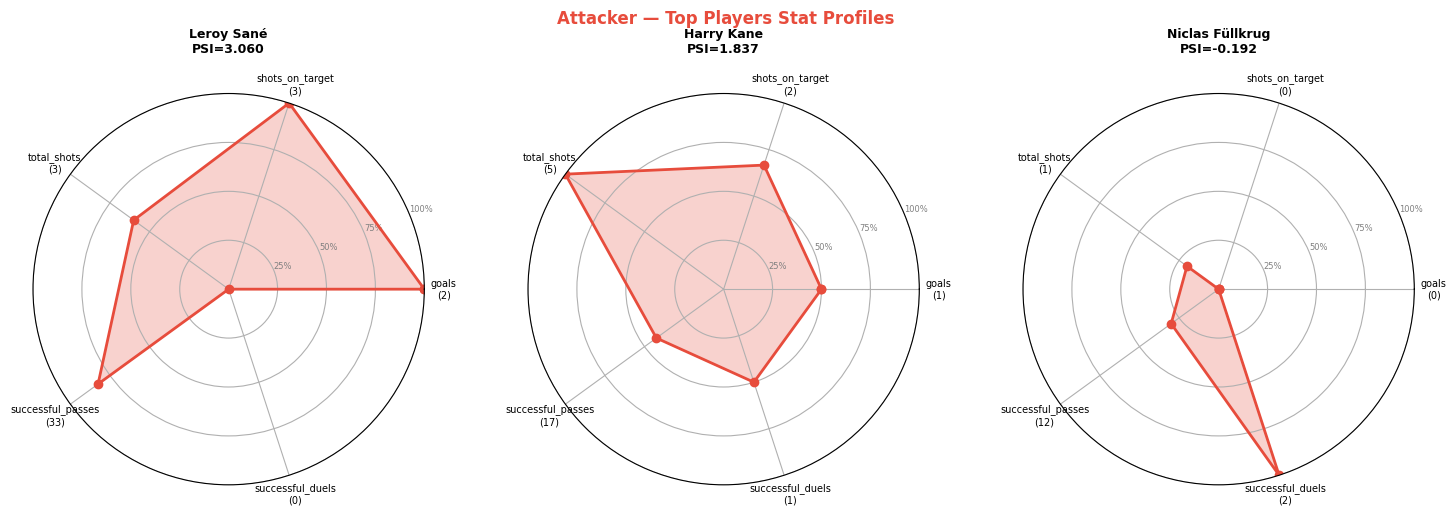

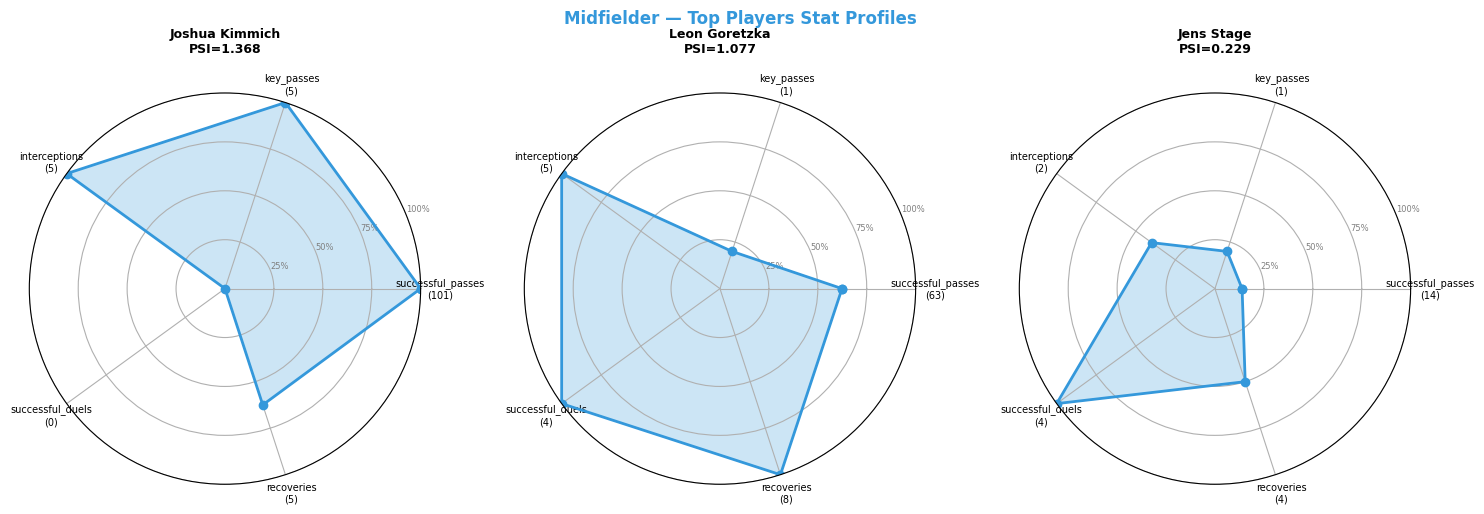

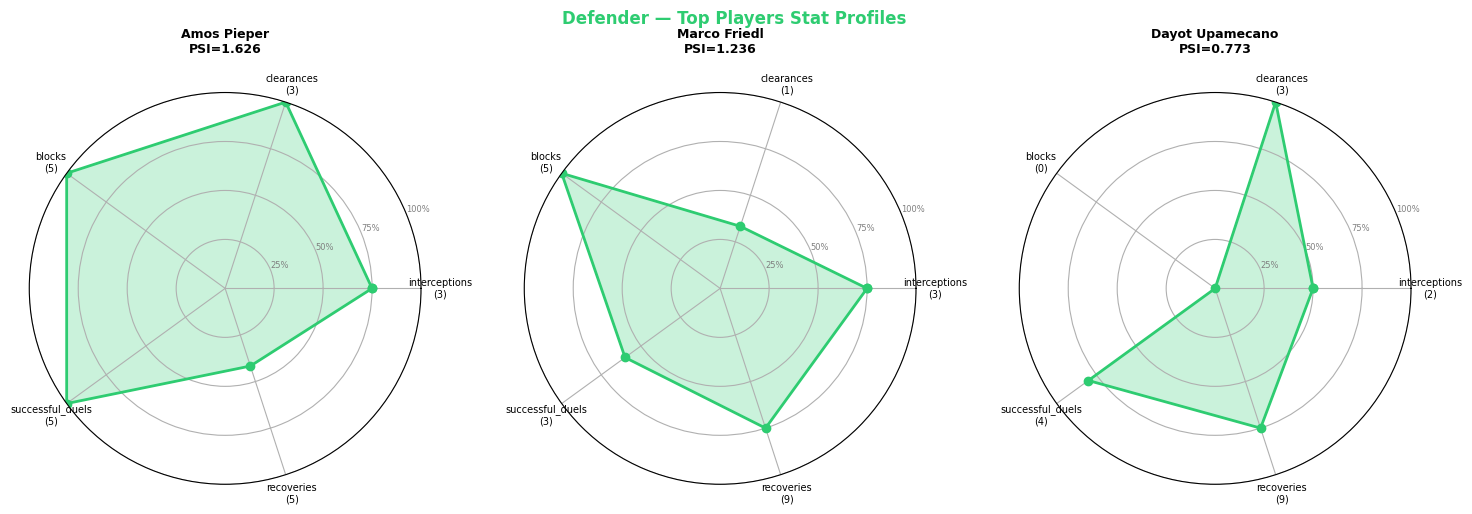

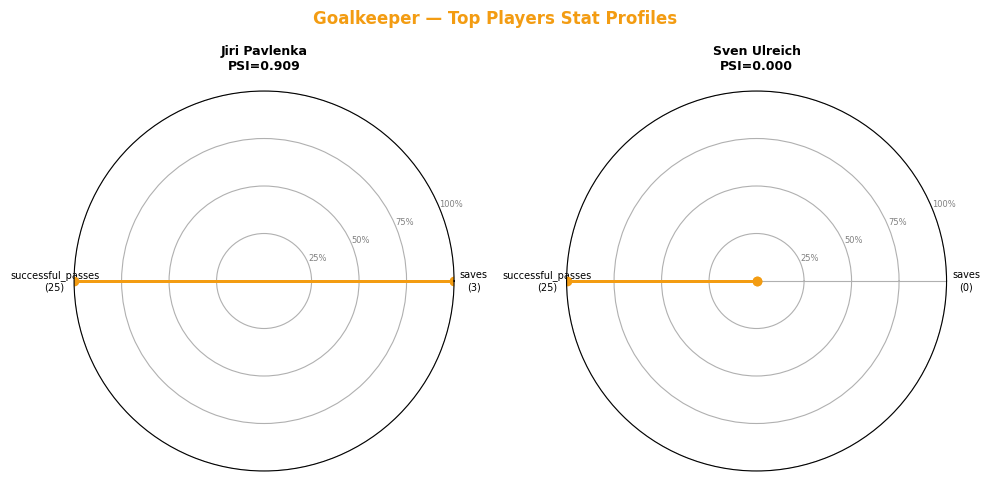

In [ ]:
# PER-PLAYER STAT PROFILES — radar charts for top players by position group
from math import pi

def radar_chart(ax, categories, values, title, color, max_vals=None):
    """Draw a radar/spider chart on the given axes."""
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # close the polygon

    # Normalize values to [0, 1] range
    if max_vals is None:
        max_vals = [max(v, 1) for v in values]
    norm_vals = [v / m if m > 0 else 0 for v, m in zip(values, max_vals)]
    norm_vals += norm_vals[:1]

    ax.plot(angles, norm_vals, 'o-', linewidth=2, color=color)
    ax.fill(angles, norm_vals, alpha=0.25, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=7)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(["25%", "50%", "75%", "100%"], size=6, color="gray")
    ax.set_title(title, size=9, fontweight="bold", pad=15)

# Pick top 2 players per position group (by PSI) for radar comparison
for grp in GROUP_ORDER:
    grp_pids = [pid for pid in all_pids if player_group.get(pid) == grp]
    grp_pids.sort(key=lambda p: psi.get(p, 0), reverse=True)
    top_pids = grp_pids[:min(3, len(grp_pids))]

    if not top_pids:
        continue

    # Get the stat categories for this group
    weights = WEIGHT_MAP.get(grp, MIDFIELDER_WEIGHTS)
    stat_names = list(weights.keys())

    # Compute max values across the group for normalization
    max_vals = []
    for s in stat_names:
        vals_in_grp = [float(player_event_stats[pid].get(s, 0)) for pid in grp_pids]
        max_vals.append(max(vals_in_grp) if vals_in_grp else 1)

    fig, axes = plt.subplots(1, len(top_pids), figsize=(5 * len(top_pids), 5),
                              subplot_kw=dict(polar=True))
    if len(top_pids) == 1:
        axes = [axes]

    fig.suptitle(f"{grp} — Top Players Stat Profiles", fontsize=12,
                 fontweight="bold", color=group_colors.get(grp, "gray"))

    for ax, pid in zip(axes, top_pids):
        name = player_id_to_name.get(pid, pid)
        values = [float(player_event_stats[pid].get(s, 0)) for s in stat_names]
        # Add raw values to labels
        labels = [f"{s}\n({int(v)})" for s, v in zip(stat_names, values)]
        radar_chart(ax, labels, values, f"{name}\nPSI={psi.get(pid, 0):.3f}",
                   group_colors.get(grp, "gray"), max_vals)

    plt.tight_layout()
    plt.show()

In [167]:
# OPTIMAL SQUAD SELECTION — MILP (Gurobi)
import gurobipy as gp
from gurobipy import GRB

# Configurable formation
# Edit these counts to change the desired formation.
# Keys MUST match the keys in POSITION_GROUPS above.
FORMATION: dict[str, int] = {
    "Attacker":   3,
    "Midfielder": 4,
    "Defender":   3,
    "Goalkeeper":  1,
}

TOTAL_SQUAD = sum(FORMATION.values())
print(f"Formation: {FORMATION}  (total = {TOTAL_SQUAD})")


def select_optimal_squad(
    synergy_df: pd.DataFrame,
    player_ids: list[str],
    player_group_map: dict[str, str],
    formation: dict[str, int],
    team_label: str = "",
) -> dict:
    """
    Solve a Mixed-Integer Linear Program to select the squad that maximizes
    total pairwise synergy.

    Parameters
    ----------
    synergy_df : pd.DataFrame
        Square synergy matrix indexed/columned by player *names*.
    player_ids : list[str]
        Player IDs in the same order as synergy_df rows/columns.
    player_group_map : dict[str, str]
        player_id → position group name.
    formation : dict[str, int]
        Position group → number of players required.
    team_label : str
        Label for display only.

    Returns
    -------
    dict with keys: "players" (list of selected pid), "score" (float),
                    "status" (str), "by_group" (dict[str, list[str]])
    """
    n = len(player_ids)
    S = synergy_df.values  # (n, n) numpy array
    total = sum(formation.values())

    model = gp.Model(f"squad_{team_label}")
    model.setParam("OutputFlag", 0)  # suppress solver log

    # Binary decision variables: x_i = 1 if player i is selected
    x = model.addVars(n, vtype=GRB.BINARY, name="x")

    # Auxiliary variables for linearisation: y_ij (i < j)
    y = {}
    for i in range(n):
        for j in range(i + 1, n):
            y[i, j] = model.addVar(lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS,
                                   name=f"y_{i}_{j}")

    # ── Objective: maximise Σ_{i<j} S[i,j] * y_ij  +  Σ_i S[i,i] * x_i ──
    obj = gp.LinExpr()
    for i in range(n):
        obj += S[i, i] * x[i]  # diagonal: individual player value
    for i in range(n):
        for j in range(i + 1, n):
            # Use average of S[i,j] and S[j,i] for symmetry robustness
            sij = (S[i, j] + S[j, i]) / 2.0
            obj += sij * y[i, j]
    model.setObjective(obj, GRB.MAXIMIZE)

    # ── McCormick linearisation: y_ij ≤ x_i, y_ij ≤ x_j, y_ij ≥ x_i+x_j-1
    for i in range(n):
        for j in range(i + 1, n):
            model.addConstr(y[i, j] <= x[i])
            model.addConstr(y[i, j] <= x[j])
            model.addConstr(y[i, j] >= x[i] + x[j] - 1)

    # Per-position cardinality constraints
    for grp, count in formation.items():
        indices = [k for k in range(n) if player_group_map.get(player_ids[k]) == grp]
        if len(indices) < count:
            print(f"  WARNING: only {len(indices)} players in group '{grp}' "
                  f"but formation requires {count}")
        model.addConstr(gp.quicksum(x[k] for k in indices) == count,
                        name=f"pos_{grp}")

    # Total squad size (safety)
    model.addConstr(gp.quicksum(x[i] for i in range(n)) == total, name="total")

    # Solve
    model.optimize()

    if model.Status != GRB.OPTIMAL:
        return {"players": [], "score": 0.0, "status": model.Status, "by_group": {}}

    selected = [player_ids[i] for i in range(n) if x[i].X > 0.5]
    by_group = {}
    for grp in formation:
        by_group[grp] = [pid for pid in selected
                         if player_group_map.get(pid) == grp]

    return {
        "players": selected,
        "score": model.ObjVal,
        "status": "OPTIMAL",
        "by_group": by_group,
    }


# Run per team
team_results: dict[str, dict] = {}

for _team in dataset.metadata.teams:
    tid = str(_team.team_id)
    tname = _team.name if hasattr(_team, "name") else tid

    # Filter to this team's players that appear in the interaction matrix
    team_pids = [pid for pid in all_pids if player_team.get(pid) == tid]
    team_names = [player_id_to_name.get(pid, pid) for pid in team_pids]

    # Extract the sub-matrix for this team
    team_synergy = interaction_df.loc[team_names, team_names]

    print(f"\n{'='*60}")
    print(f"Team: {tname} (id={tid})  —  {len(team_pids)} players in matrix")
    print(f"Formation: {FORMATION}")

    # Check feasibility
    available = {}
    for grp, count in FORMATION.items():
        avail = sum(1 for pid in team_pids if player_group.get(pid) == grp)
        available[grp] = avail
        status = "OK" if avail >= count else "SHORTAGE"
        print(f"  {grp}: need {count}, have {avail}  [{status}]")

    result = select_optimal_squad(
        synergy_df=team_synergy,
        player_ids=team_pids,
        player_group_map=player_group,
        formation=FORMATION,
        team_label=tname,
    )
    team_results[tid] = result

    if result["status"] == "OPTIMAL":
        print(f"\n  ✓ Optimal squad found — Total synergy: {result['score']:.6f}")
        for grp in GROUP_ORDER:
            members = result["by_group"].get(grp, [])
            for pid in members:
                name = player_id_to_name.get(pid, pid)
                pos  = player_position.get(pid, "?")
                print(f"    [{grp:>11}]  {name} ({pos})")
    else:
        print(f"\n  ✗ No optimal solution found (status={result['status']})")
        print("    Check that the team has enough players per position group.")

Formation: {'Attacker': 3, 'Midfielder': 4, 'Defender': 3, 'Goalkeeper': 1}  (total = 11)

Team: SV Werder Bremen (id=38)  —  16 players in matrix
Formation: {'Attacker': 3, 'Midfielder': 4, 'Defender': 3, 'Goalkeeper': 1}
  Attacker: need 3, have 4  [OK]
  Midfielder: need 4, have 5  [OK]
  Defender: need 3, have 6  [OK]
  Goalkeeper: need 1, have 1  [OK]

  ✓ Optimal squad found — Total synergy: 3.316604
    [   Attacker]  Dawid Kownacki (ST)
    [   Attacker]  Oliver Burke (RW)
    [   Attacker]  Niclas Füllkrug (ST)
    [ Midfielder]  Leonardo Bittencourt (LAM)
    [ Midfielder]  Jens Stage (RAM)
    [ Midfielder]  Romano Schmid (CAM)
    [ Midfielder]  Senne Lynen (CDM)
    [   Defender]  Leon Opitz (LWB)
    [   Defender]  Marco Friedl (LCB)
    [   Defender]  Amos Pieper (RCB)
    [ Goalkeeper]  Jiri Pavlenka (GK)

Team: FC Bayern München (id=33)  —  16 players in matrix
Formation: {'Attacker': 3, 'Midfielder': 4, 'Defender': 3, 'Goalkeeper': 1}
  Attacker: need 3, have 5  [OK]


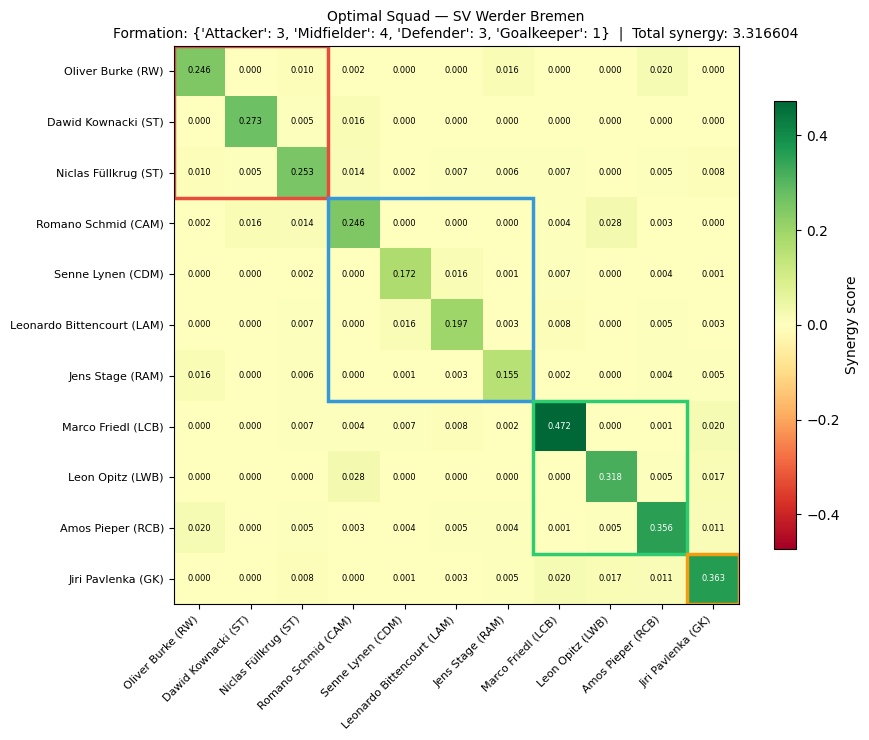


SV Werder Bremen — Bench players:
  Mitchell Weiser (RWB, Defender)
  Milos Veljkovic (CB, Defender)
  Anthony Jung (LWB, Defender)
  Christian Groß (CDM, Midfielder)
  Marvin Ducksch (ST, Attacker)


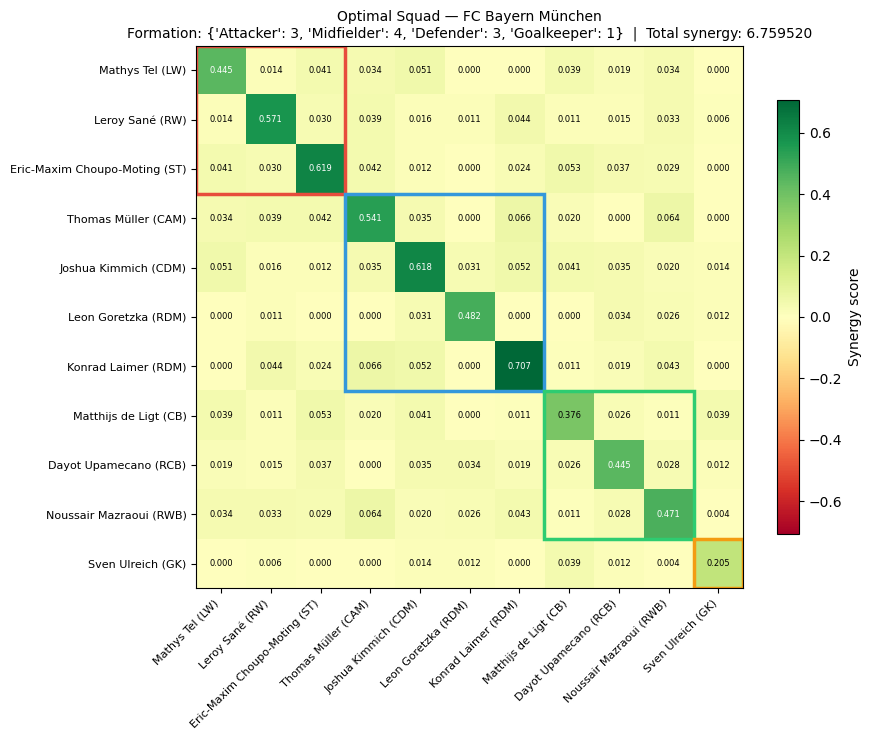


FC Bayern München — Bench players:
  Harry Kane (ST, Attacker)
  Kingsley Coman (LW, Attacker)
  Alphonso Davies (LWB, Defender)
  Min-jae Kim (LCB, Defender)
  Jamal Musiala (CAM, Midfielder)


In [168]:
# RESULTS VISUALISATION — Selected Squad Heatmaps
from matplotlib.patches import Rectangle

for _team in dataset.metadata.teams:
    tid   = str(_team.team_id)
    tname = _team.name if hasattr(_team, "name") else tid
    result = team_results.get(tid)

    if not result or result["status"] != "OPTIMAL":
        print(f"\n{tname}: no optimal solution — skipping visualisation.")
        continue

    selected_pids = set(result["players"])

    # Build ordered list for this team's selected players
    # Order: by position group, then by position code within group
    sel_ordered = []
    for grp in GROUP_ORDER:
        grp_sel = [pid for pid in result["by_group"].get(grp, [])]
        grp_sel.sort(key=lambda p: player_position.get(p, ""))
        sel_ordered.extend(grp_sel)

    sel_names = [player_id_to_name.get(pid, pid) for pid in sel_ordered]
    sel_labels = [
        f"{player_id_to_name.get(pid, pid)} ({player_position.get(pid, '?')})"
        for pid in sel_ordered
    ]

    # Extract the 11×11 sub-matrix for selected players
    sel_matrix = interaction_df.loc[sel_names, sel_names]

    fig, ax = plt.subplots(figsize=(9, 7.5))

    vmax = np.abs(sel_matrix.values).max() or 1.0
    norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
    im = ax.imshow(sel_matrix.values, cmap="RdYlGn", norm=norm, aspect="auto")

    ax.set_xticks(range(len(sel_ordered)))
    ax.set_yticks(range(len(sel_ordered)))
    ax.set_xticklabels(sel_labels, rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(sel_labels, fontsize=8)

    # Annotate each cell with the synergy value
    for i in range(len(sel_ordered)):
        for j in range(len(sel_ordered)):
            val = sel_matrix.values[i, j]
            color = "white" if abs(val) > vmax * 0.6 else "black"
            ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                    fontsize=6, color=color)

    # Draw position-group boxes
    cum = 0
    for grp in GROUP_ORDER:
        count = len(result["by_group"].get(grp, []))
        if count > 0:
            rect = Rectangle((cum - 0.5, cum - 0.5), count, count,
                              linewidth=2.5, edgecolor=group_colors.get(grp, "gray"),
                              facecolor="none", linestyle="-")
            ax.add_patch(rect)
            cum += count

    plt.colorbar(im, ax=ax, label="Synergy score", shrink=0.8)
    ax.set_title(
        f"Optimal Squad — {tname}\n"
        f"Formation: {FORMATION}  |  Total synergy: {result['score']:.6f}",
        fontsize=10,
    )
    plt.tight_layout()
    plt.show()

    # Print comparison: selected vs bench
    team_pids_all = [pid for pid in all_pids if player_team.get(pid) == tid]
    bench = [pid for pid in team_pids_all if pid not in selected_pids]

    print(f"\n{tname} — Bench players:")
    for pid in bench:
        name = player_id_to_name.get(pid, pid)
        pos  = player_position.get(pid, "?")
        grp  = player_group.get(pid, "?")
        print(f"  {name} ({pos}, {grp})")